# Prédiction du trafic New Yorkais 

## Objectif de l'étude

Dans le cas de l'UV à projet TX00, une étude est réalisée pour réussir à fluidifier le trafic New Yorkais. Le but de cette étude est de pouvoir prédire le traffic en fonction de différents critères pour, par la suite, proposer des solutions pour fluidifier le traffic. Pour cette étude, la donnée est directement prise depuis des opens data sur le site officielle de la ville. 

## Données utilisées

Les données utilisées dans cette étude regroupent trois DataFrames. Le premier regroupe plusieurs informations importantes :

- le nom de la route étudié (Roadway name)
- la Date
- l'heure
- le compte de véhicule passée par ce segment durant l'intervalle horaire.

Les deux autres jeux de données contiennent les informations météorologiques de New York dans le même espace de temps que le premier jeu de donnée. Les informations météorologiques sont les suivantes :

- max temp, min temp, temp : degre
- wind chill, heat index : degre
- precipitation : mm ou %
- snow : cm
- snow depth : cm
- wind speed, wind gust : kph
- wind direction :
- visibility : km
- cloud cover : %
- relative humidity : %
- Conditions : string 

## Théorie du traffic

### Principe

Un écoulement de trafic sur un réseau routier présente de nombreuses similitudes avec l'écoulement d'un fluide. La première similitude concerne la définition du réseau qui se compose de tuyaux (les sections routières), de jonctions (les carrefours), de bifurcations, de zones d’échanges, de lieux de stockage, etc. Les similitudes se poursuivent dans la définition de la demande qui irrigue le réseau : elle s’écoule de l’amont vers l’aval. Et lorsqu’elle s’écoule sur le réseau, on observe des débordements (les congestions) lorsque la capacité du réseau ne suffit pas à écouler tout le volume de demande. Ces débordements peuvent rester locaux ou bien perturber le fonctionnement global du réseau.
Ces similitudes nous amènent à utiliser les mêmes variables issues de la mécanique des fluides pour décrire les états de trafic routier : le débit, la vitesse et la densité (concentration). Ces variables se définissent ainsi :

le débit Q représente le nombre de véhicules N passés pendant une période Δt en un point donné.
Q = N/Δt

la concentration K représente le nombre de véhicules N présents sur une section de longueur Δx à un instant donné.
K = N/Δx

La vitesse V représente la vitesse de déplacement du flot de véhicules. Cette vitesse peut être calculée à partir du débit et de la concentration : V =Q/ K

Les variables de débit, de vitesse et de concentration sont donc liées entre elles (par la
relation Q=K*V, et la relation (dite fondamentale) qui les relie deux à deux constitue le
diagramme fondamental (DF)

### Propriétés mathématiques 

Ces propriétés sont les suivantes :

■ Les valeurs de débit sont positives ou nulles.

■ Le diagramme fondamental est continu, sur une plage de concentration bornée,
comprise entre une concentration nulle (en cas d’absence de véhicule) et une
concentration maximale (lorsque tous les véhicules sont à l’arrêt dans une file d’attente).
Sur cette plage de concentration, chaque valeur de concentration correspond à une valeur
de débit unique.

■ Le diagramme fondamental est concave.
Compte tenu de ces trois propriétés, seul le diagramme du bas respecte les propriétés de
continuité et de concavité.

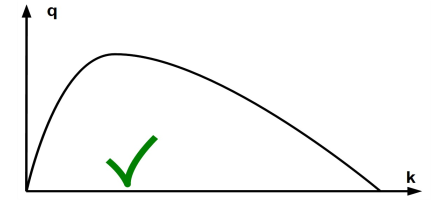

### Propriétés physiques

il est courant de faire l’analogie entre l’écoulement
du trafic et l’écoulement d’un fluide. En effet, les propriétés physiques de l’un et de l’autre
sont similaires. Ainsi, l’écoulement du trafic peut se diviser en deux catégories de régimes :

■ un régime fluide. Ce régime s’observe lorsque la demande de trafic est inférieure à la
capacité (aussi appelée offre) de la section. Aucune contrainte ne s’exerce sur le trafic, et
l’état de trafic mesuré correspond exactement à la demande. Le débit est alors
proportionnel à la concentration et le coefficient de proportionnalité correspond à la
vitesse libre de la section (généralement proche de la vitesse réglementaire).

■ un régime congestionné. Ce régime s’observe lorsque la demande de trafic est
supérieure à la capacité d’écoulement de la section. Seule l’offre disponible peut
s’écouler, le débit est alors contraint et il décroît à mesure que le trafic se densifie.
L’état de trafic séparant les régimes fluide et congestionné est appelé « état critique », et
il correspond au fonctionnement à capacité C. Cette différence de régime traduit
d’ailleurs la concavité du diagramme fondamental. 

Tout ceci est illustré par la figure
suivante :

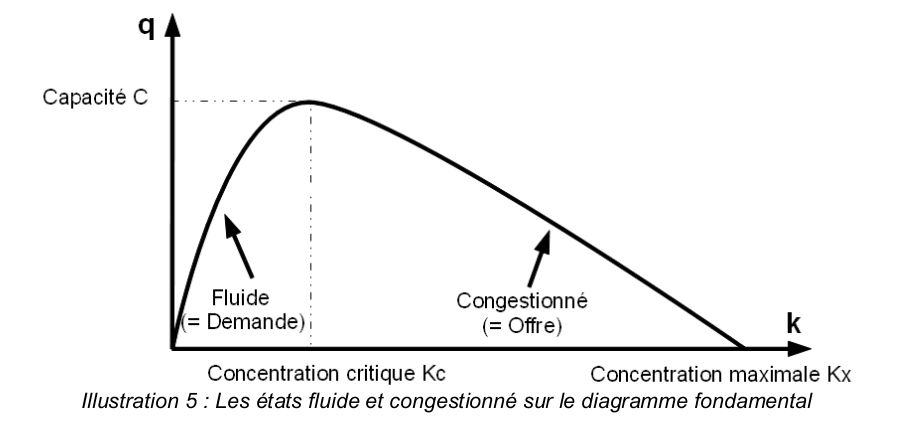

## Introduction

Dans notre étude, nous nous intéresserons d'abord à l'étude du trafic sur un tronçon précis de la circulation New Yorkaise. Le tronçon en question est la 3ième avenue entre East 154 street et East 155 street.

Nous connaissons actuellement le débit (donné dans notre dataset) et la longueur de notre section (voir image ci dessus). La vitesse des véhicules est de 30mph, cette vitesse moyenne peut être utilisé pour déterminer la concentration. 

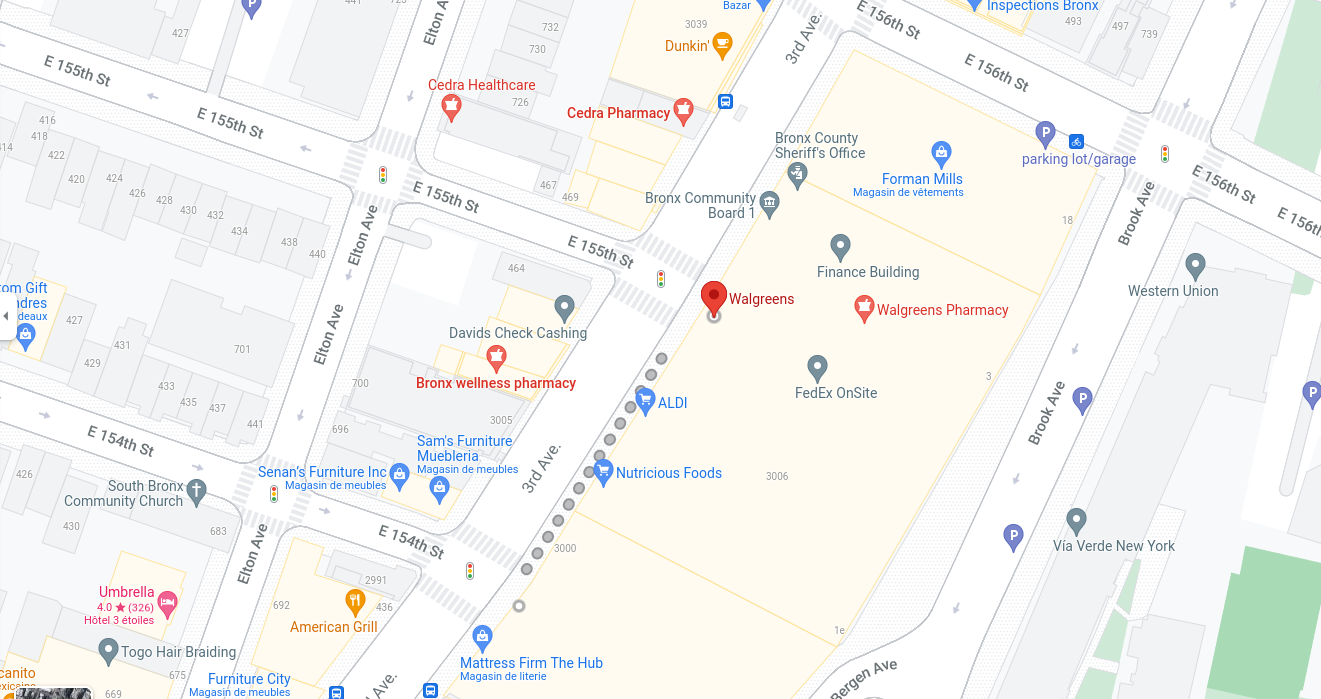

### Critères d'erreur pour évaluer la pertinence de ma prédiction

Au vu de nos données, l'objectif est de prédire le volume de véhicule en fonction de différents paramètres. Pour évaluer la pertinence de notre régression, l'erreur sera mesuré sur le volume de véhicule.

### Hypothèses

Les données récupérées dans notre dataset concernent seulement des prélèvements allant du 13/09/2014 au 21/09/2014 puis du 22/10/2017 au 01/11/2017. De ce fait, nous négligeons l'importance de l'année dans notre étude et comme ces deux années sont proches, nous supposons que l'année n'a pas d'impact sur le traffic.

De plus, nos prélèvement ne concernent qu'un mois dans l'année. Cela ne regroupe pas toutes les conditions météorologiques possiblent dans une année. Ainsi certains paramètres météorologiques pourraient avoir peu d'impact dans notre étude alors que le contraire serait possible dans la vie réelle. 

## Import des modules 

In [1]:
from statsmodels.tsa.stattools import coint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import my_file
import seaborn as sns
from scipy import stats
#regression
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

#model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score,mean_absolute_error, make_scorer 
# from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score  # for classification 

## Import de la donnée

In [2]:
# Télécharger la donnée
dataset = pd.read_csv("Traffic_Volume_Counts__2014-2019_.csv")
df_weather_2014 =pd.read_csv("history_data_2014.csv")
df_weather_2017 = pd.read_csv("history_data_2017.csv")
#Combinaisons de 3 dataset

In [3]:
dataset.shape

(27289, 31)

In [30]:
#Ajout des données météorologique présent dans les deux autres dataset
df_weather = pd.concat([df_weather_2014,df_weather_2017])

In [31]:
df_weather["Date"] = pd.to_datetime(df_weather["Date time"],format='%m/%d/%Y %H:%M:%S')
df_weather.head(4)

Name            Date time  Maximum Temperature  \
0  New York, NY, United States  09/13/2014 00:00:00                 17.0   
1  New York, NY, United States  09/13/2014 01:00:00                 16.8   
2  New York, NY, United States  09/13/2014 02:00:00                 16.2   
3  New York, NY, United States  09/13/2014 03:00:00                 16.0   

   Minimum Temperature  Temperature  Wind Chill  Heat Index  Precipitation  \
0                 17.0         17.0         NaN         NaN            0.0   
1                 16.8         16.8         NaN         NaN            0.0   
2                 16.2         16.2         NaN         NaN            0.0   
3                 16.0         16.0         NaN         NaN            0.0   

   Snow  Snow Depth  Wind Speed  Wind Direction  Wind Gust  Visibility  \
0   NaN         NaN        14.6              20        NaN        16.0   
1   NaN         NaN        16.0              38        NaN        16.0   
2   NaN         NaN        17.2              45        NaN        16.0   
3   NaN         NaN        14.9              43        NaN        16.0   

   Cloud Cover  Relative Humidity        Conditions  \
0         27.9              59.82  Partially cloudy   
1         27.9              58.73  Partially cloudy   
2         25.4              62.01  Partially cloudy   
3         45.9              65.41  Partially cloudy   

                               Contributing Stations                Date  
0  KNYC (Id=KNYC,6.6KM), NY CITY CENTRAL PARK, NY... 2014-09-13 00:00:00  
1  KNYC (Id=KNYC,6.6KM), NY CITY CENTRAL PARK, NY... 2014-09-13 01:00:00  
2  KNYC (Id=KNYC,6.6KM), NY CITY CENTRAL PARK, NY... 2014-09-13 02:00:00  
3  KNYC (Id=KNYC,6.6KM), NY CITY CENTRAL PARK, NY... 2014-09-13 03:00:00

## Third Avenue
le jeu de données permet de retrouver des informations sur plusieurs sections de routes à travers New-York, l'étude se focalise sur la troisième avenue en direction du Nord et plus précisement du croisement de l'East 154 Street au croisement de l'East 155 street.

In [4]:
#Spécifier le dataset pour se focaliser sur une seule rue
third_avenue = dataset[dataset["Roadway Name"]=="3 Avenue"]
third_avenue_NB = third_avenue[third_avenue["Direction"]=="NB"]
df_third_avenue =third_avenue_NB[third_avenue_NB["Segment ID"]==70376]
df_third_avenue.tail(4)

ID  Segment ID Roadway Name             From               To  \
16604  19       70376     3 Avenue  East 154 Street  East 155 Street   
16697  19       70376     3 Avenue  East 154 Street  East 155 Street   
16793  19       70376     3 Avenue  East 154 Street  East 155 Street   
16956  19       70376     3 Avenue  East 154 Street  East 155 Street   

      Direction        Date  12:00-1:00 AM  1:00-2:00AM  2:00-3:00AM  ...  \
16604        NB  09/28/2017          148.0        138.0         91.0  ...   
16697        NB  09/29/2017          154.0        145.0        104.0  ...   
16793        NB  09/30/2017          301.0        204.0        166.0  ...   
16956        NB  10/01/2017          238.0        215.0        156.0  ...   

       2:00-3:00PM  3:00-4:00PM  4:00-5:00PM  5:00-6:00PM  6:00-7:00PM  \
16604          545          588          621          585          672   
16697          622          652          671          624          624   
16793          569          654          625          614          595   
16956          508          569          507          449          456   

       7:00-8:00PM  8:00-9:00PM  9:00-10:00PM  10:00-11:00PM  11:00-12:00AM  
16604          568          431           371            256            209  
16697          607          511           394            351            311  
16793          467          467           325            292            284  
16956          406          392           295            262            182  

[4 rows x 31 columns]

### Changement de type de données

Dans le dataset originel, la colonne "Date" est de type string. Pour pouvoir la manipuler plus facilement, il est préférable de mettre la donnée en type "Datetime". 

In [6]:
#transformation du type string en datetime
df_third_avenue["Date"] = pd.to_datetime(df_third_avenue["Date"],format='%m/%d/%Y')
df_third_avenue["Date"].dtype

/tmp/ipykernel_73645/479734249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_third_avenue["Date"] = pd.to_datetime(df_third_avenue["Date"],format='%m/%d/%Y')


dtype('<M8[ns]')

### Réorganisation de mon DataFrame

Pour l'étude du volume de véhicule sur un tronçon, il est possible de réorganiser notre dataset pour avoir quelque chose de plus exploitable. Au lieu d'avoir une colonne pour chaque heure, la colonne "Date" s'incrémente heure par heure. Une fonction écrite dans un fichier python annexe permet de le réaliser.

In [21]:
#Réorganisation du dataset
new_df=my_file.change_dataframe(df_third_avenue)
new_df.tail(4)

Date  Count
428 2017-10-01 20:00:00  392.0
429 2017-10-01 21:00:00  295.0
430 2017-10-01 22:00:00  262.0
431 2017-10-01 23:00:00  182.0

## Exploration, prétaitement et affichage de la distribution des différents paramètres

#### Donnée de circulation

(17431.0, 17440.0)

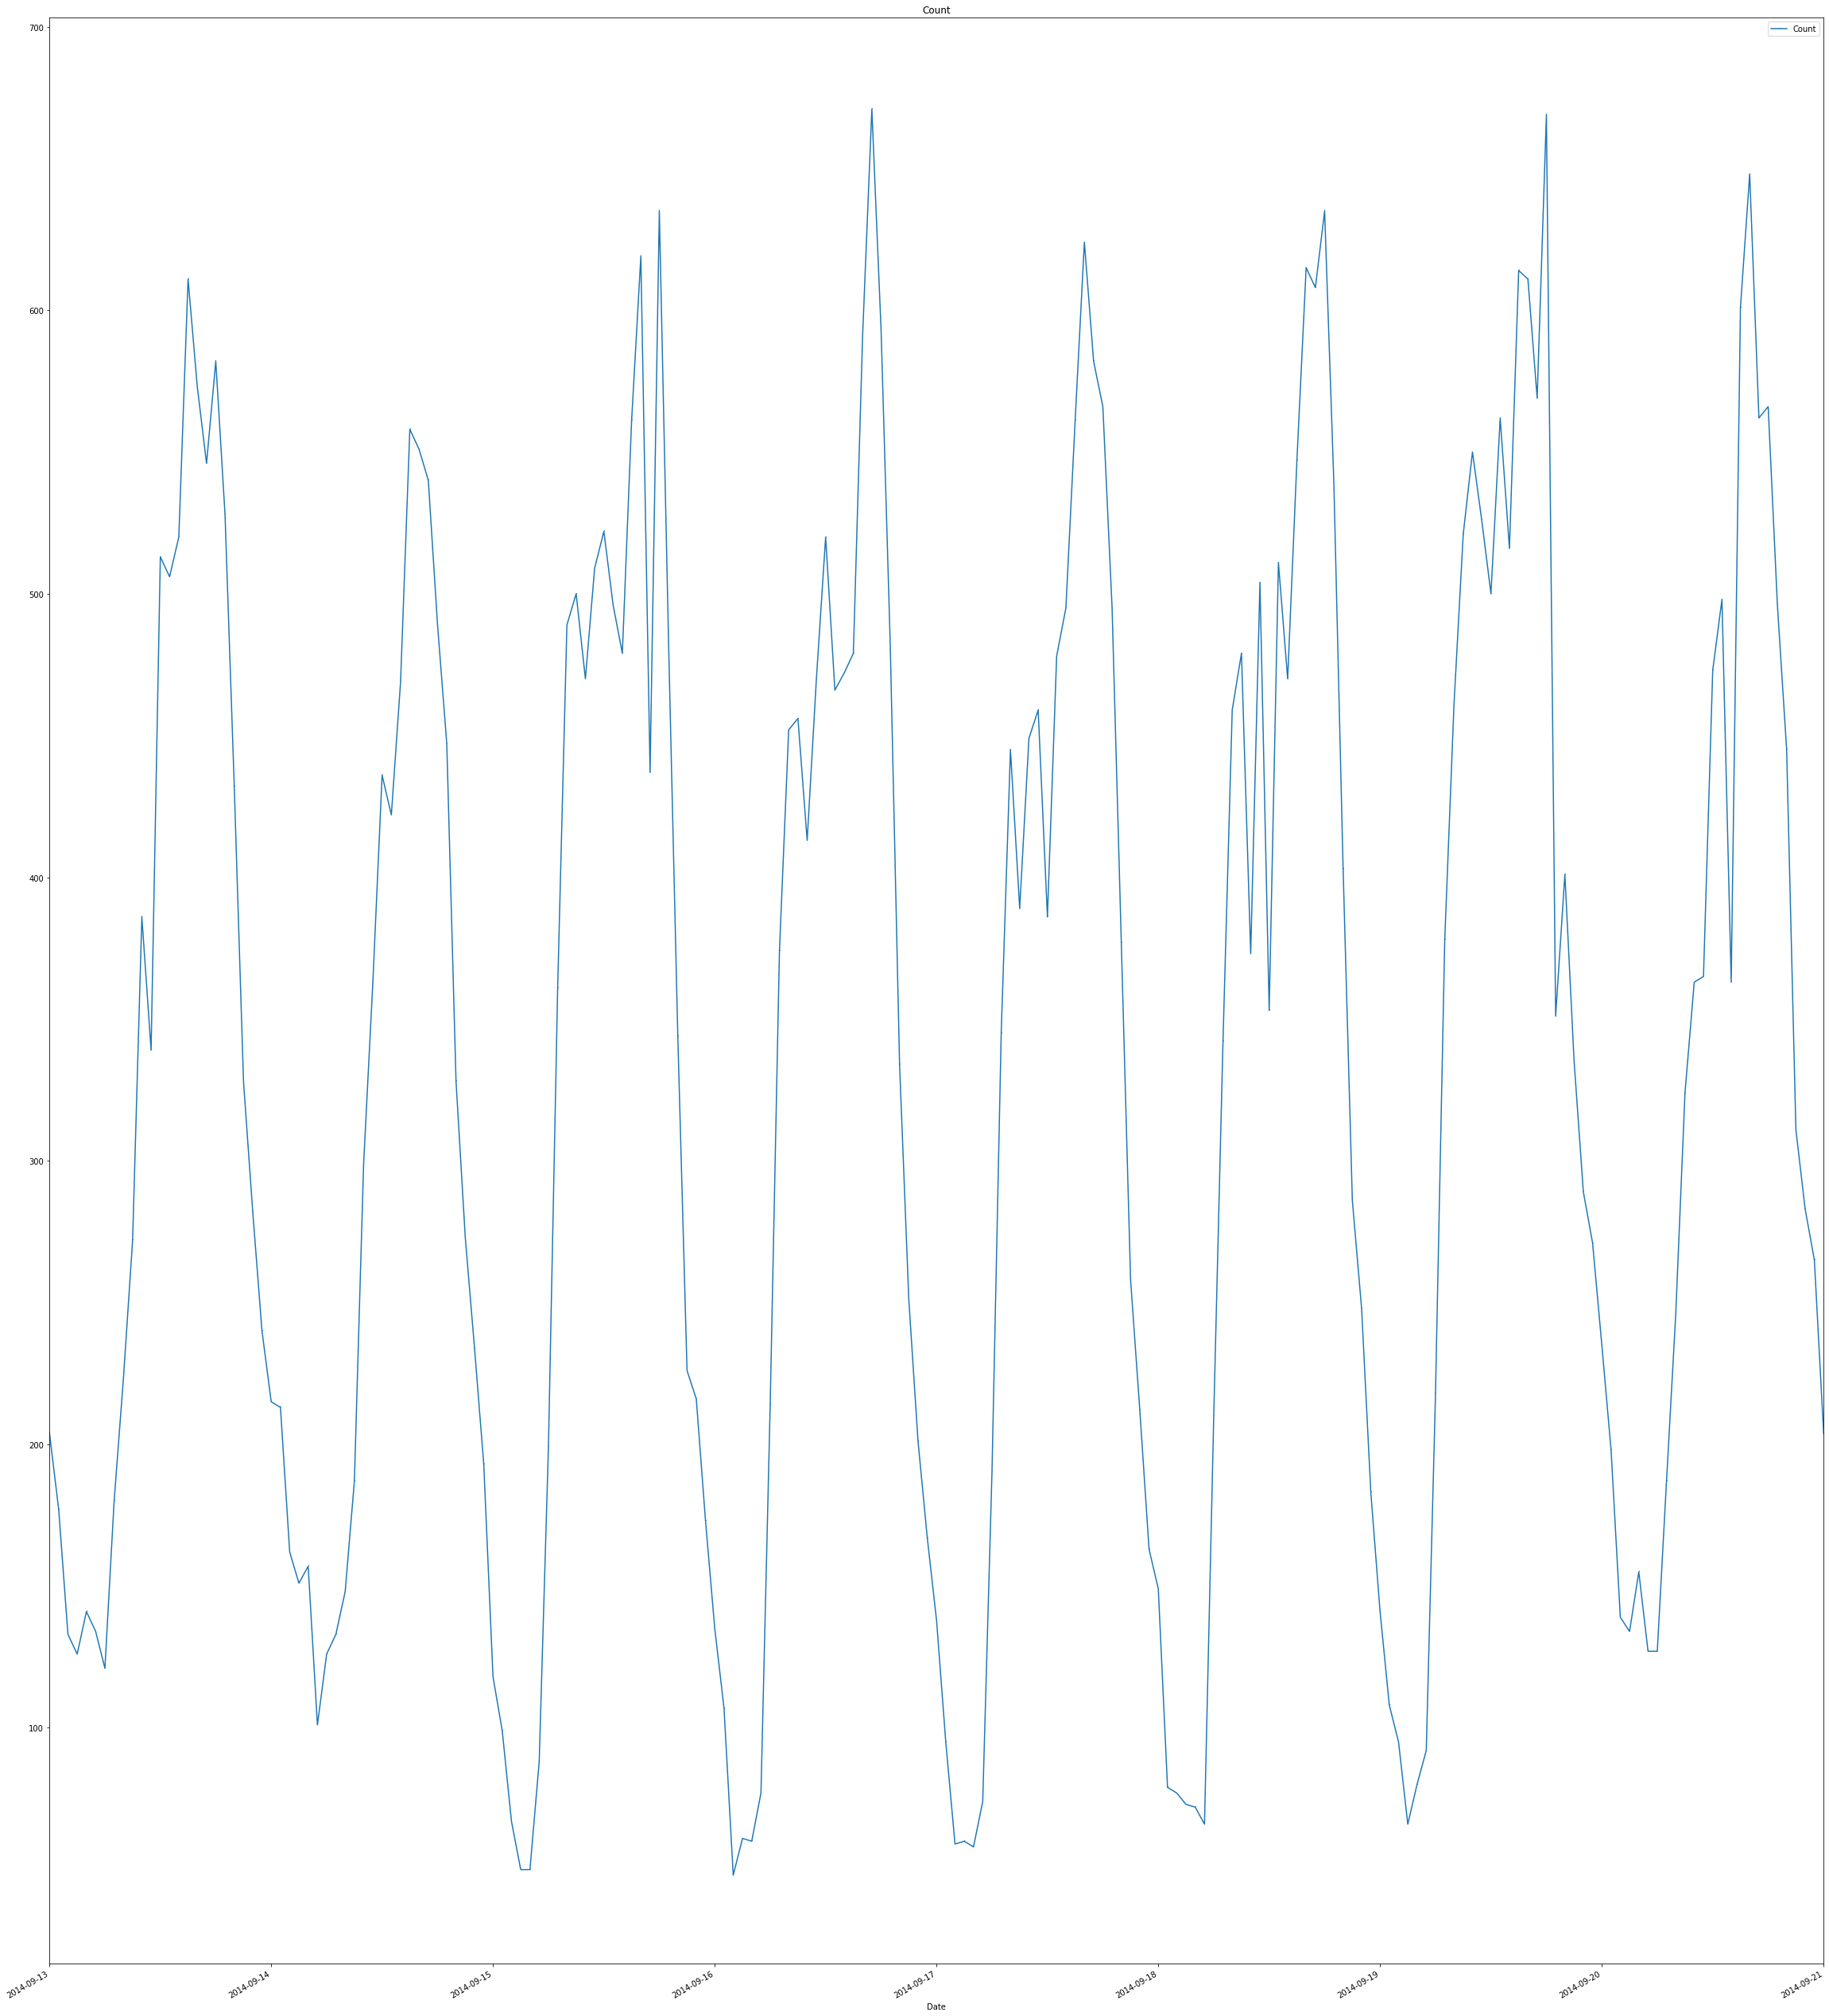

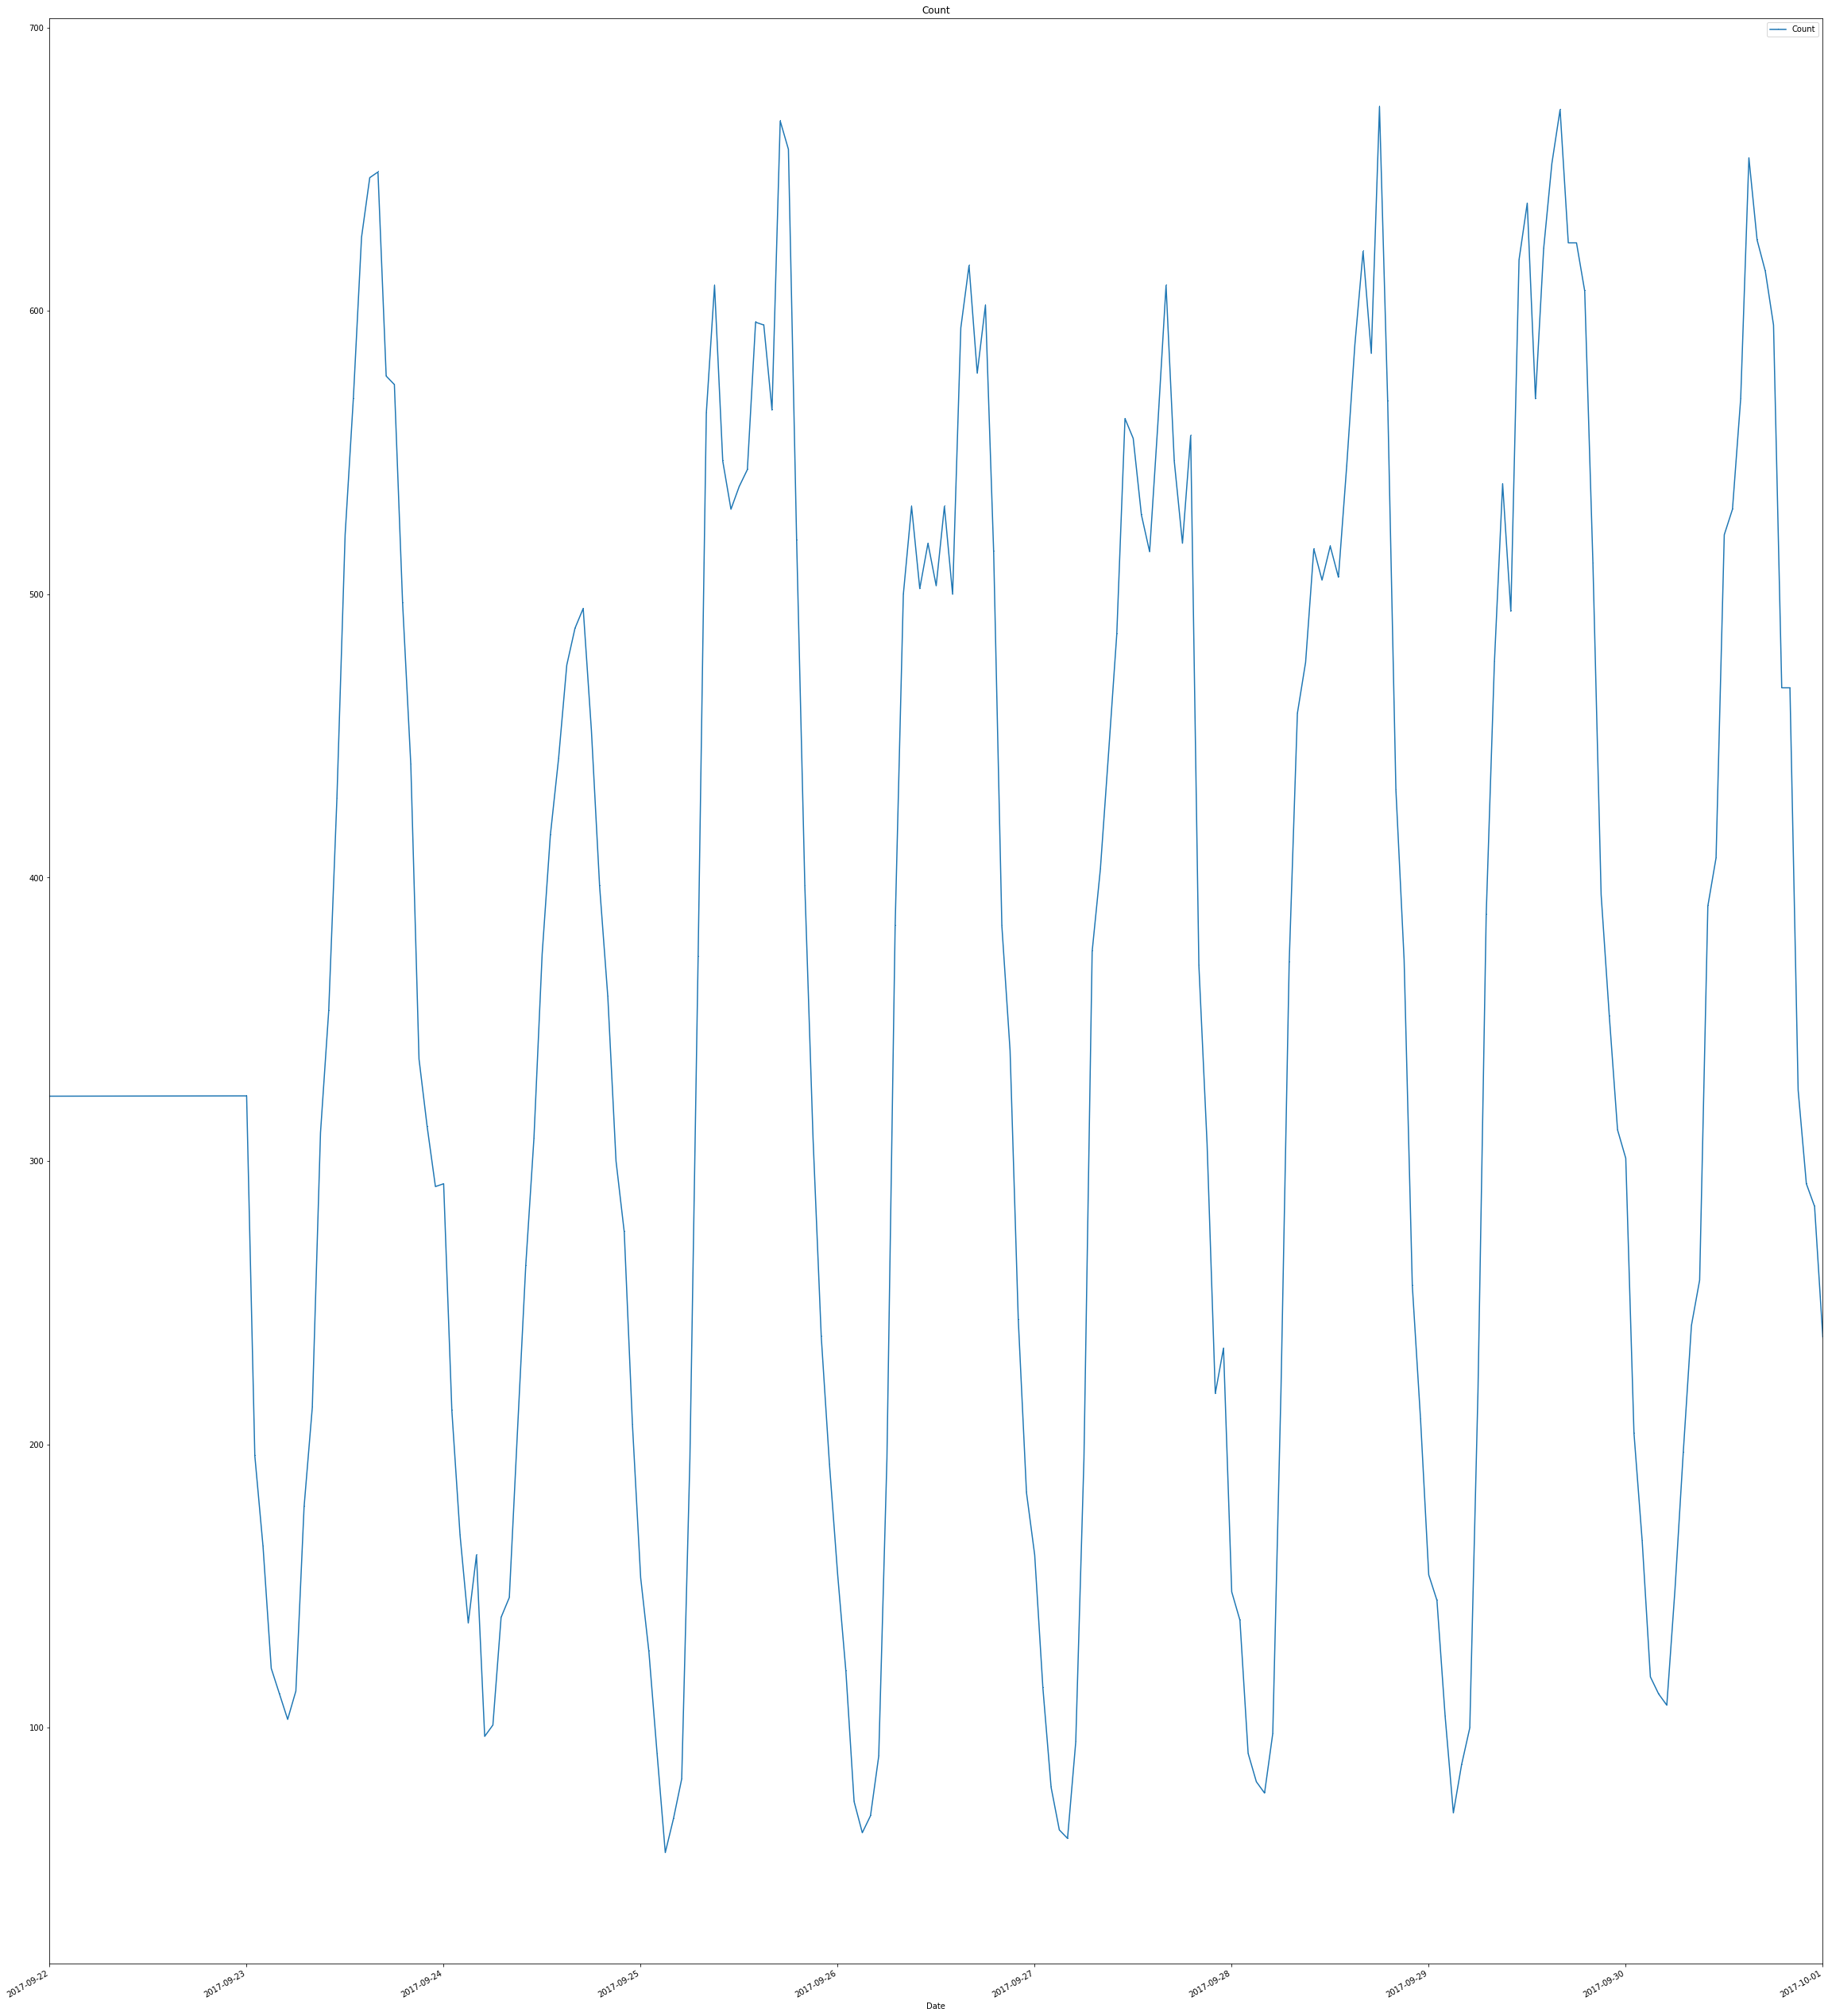

In [22]:
display_df = new_df.copy(deep=True)
display_df = display_df.set_index('Date')
display_df.plot(title = 'Count',marker=',', figsize=(40,50)).set_xlim(pd.Timestamp('2014-09-13'), pd.Timestamp('2014-09-21'))
display_df.plot(title = 'Count',marker=',', figsize=(40,50)).set_xlim(pd.Timestamp('2017-09-22'), pd.Timestamp('2017-10-01'))

Il y a une periodicité sur les graphiques. Mais on remarque des jours avec un flux plus abondant que d'autres, il est possible que certains jours les gens utilisent moins la voiture comme le week end par exemple. Pour comfirmer cela, il est possible d'extraire l'heure et le jour de la semaine lors du relevé des informations des capteurs.

##### Extraction de caractéristiques (features extraction)

Grâce aux données déjà présentent, il est possible d'extraire de nouvelles caractéristiques comme l'heure du comptage de voiture et le jour de la semaine. 

In [23]:
#Ajout de la colonne jour et heure
new_df["Hour"] = [t.hour for t in pd.DatetimeIndex(new_df.Date)]
new_df["Day"] = [t.dayofweek for t in pd.DatetimeIndex(new_df.Date)]
new_df.head(4)

Date  Count  Hour  Day
0 2014-09-13 00:00:00  204.0     0    5
1 2014-09-13 01:00:00  177.0     1    5
2 2014-09-13 02:00:00  133.0     2    5
3 2014-09-13 03:00:00  126.0     3    5

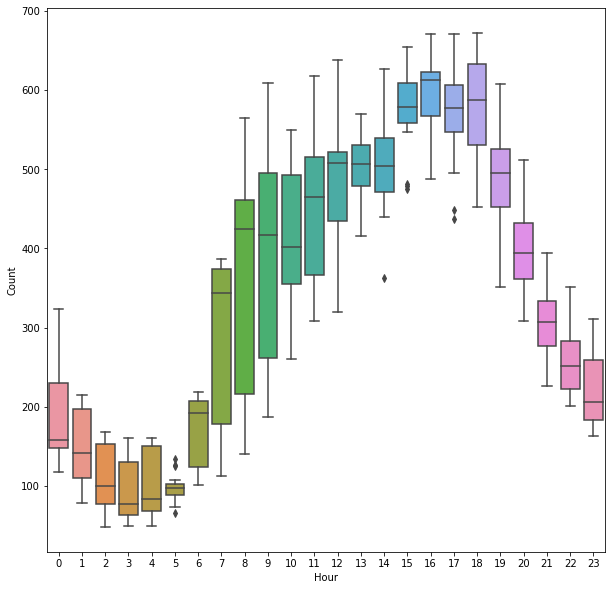

In [25]:
#Variation avec l'heure
sns.boxplot(data=new_df,y="Count",x="Hour",orient="v")
fig = plt.gcf()
fig.set_size_inches(10,10)

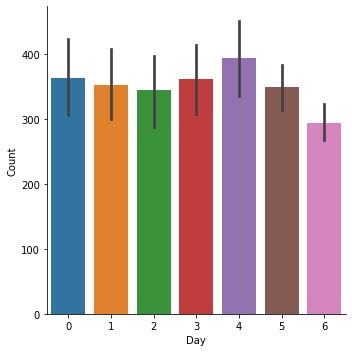

In [27]:
# Influence of the day of the week
sns.factorplot(x="Day",y='Count',kind='bar',data=new_df)
# small influence - less bike renting on Saturday (6)

Suite à ces visualisations, il est deja possible de faire deux hypothèses. Le flux de véhicule varie en fonction de l'heure, le flux est plus important en journée (entre 9h et 19h) plutot que la nuit. Il y a un pic à 17h qui pourrait s'expliquer par le retour du travail, la sortie des écoles. De plus, la circulation semble plus intense en semaine que pendant le week- end

#### Données météorologiques

(17431.0, 17440.0)

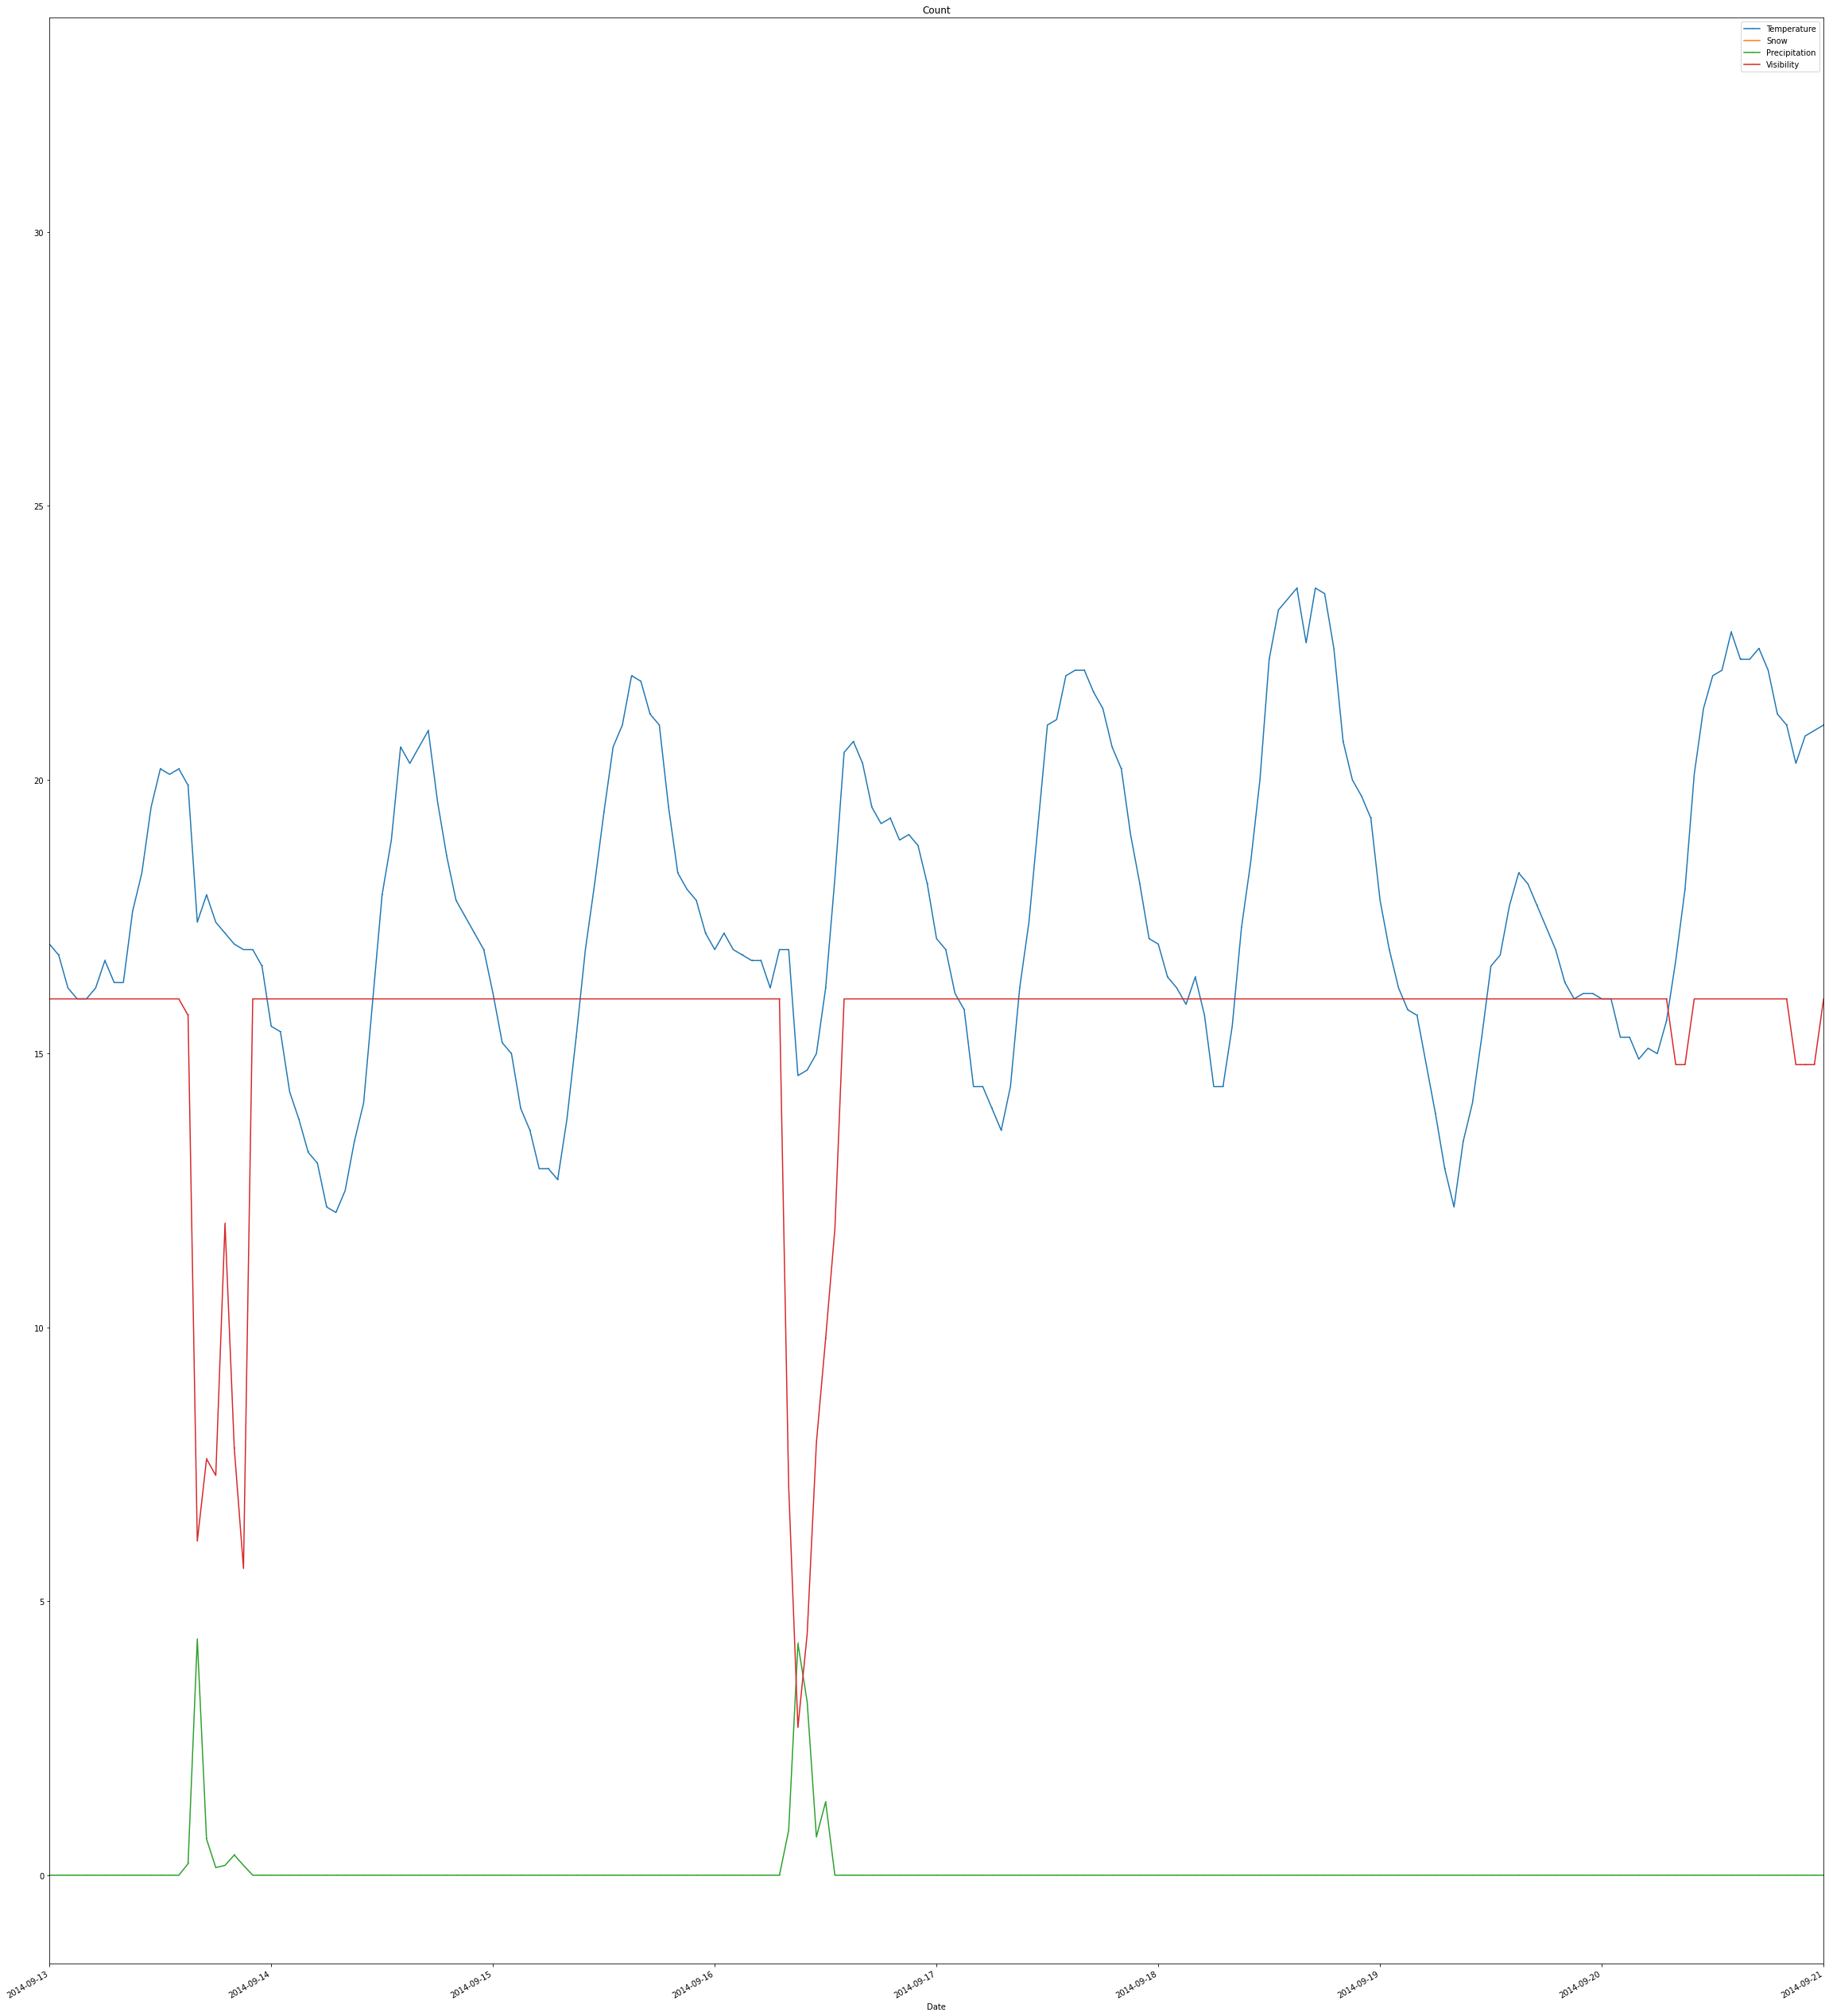

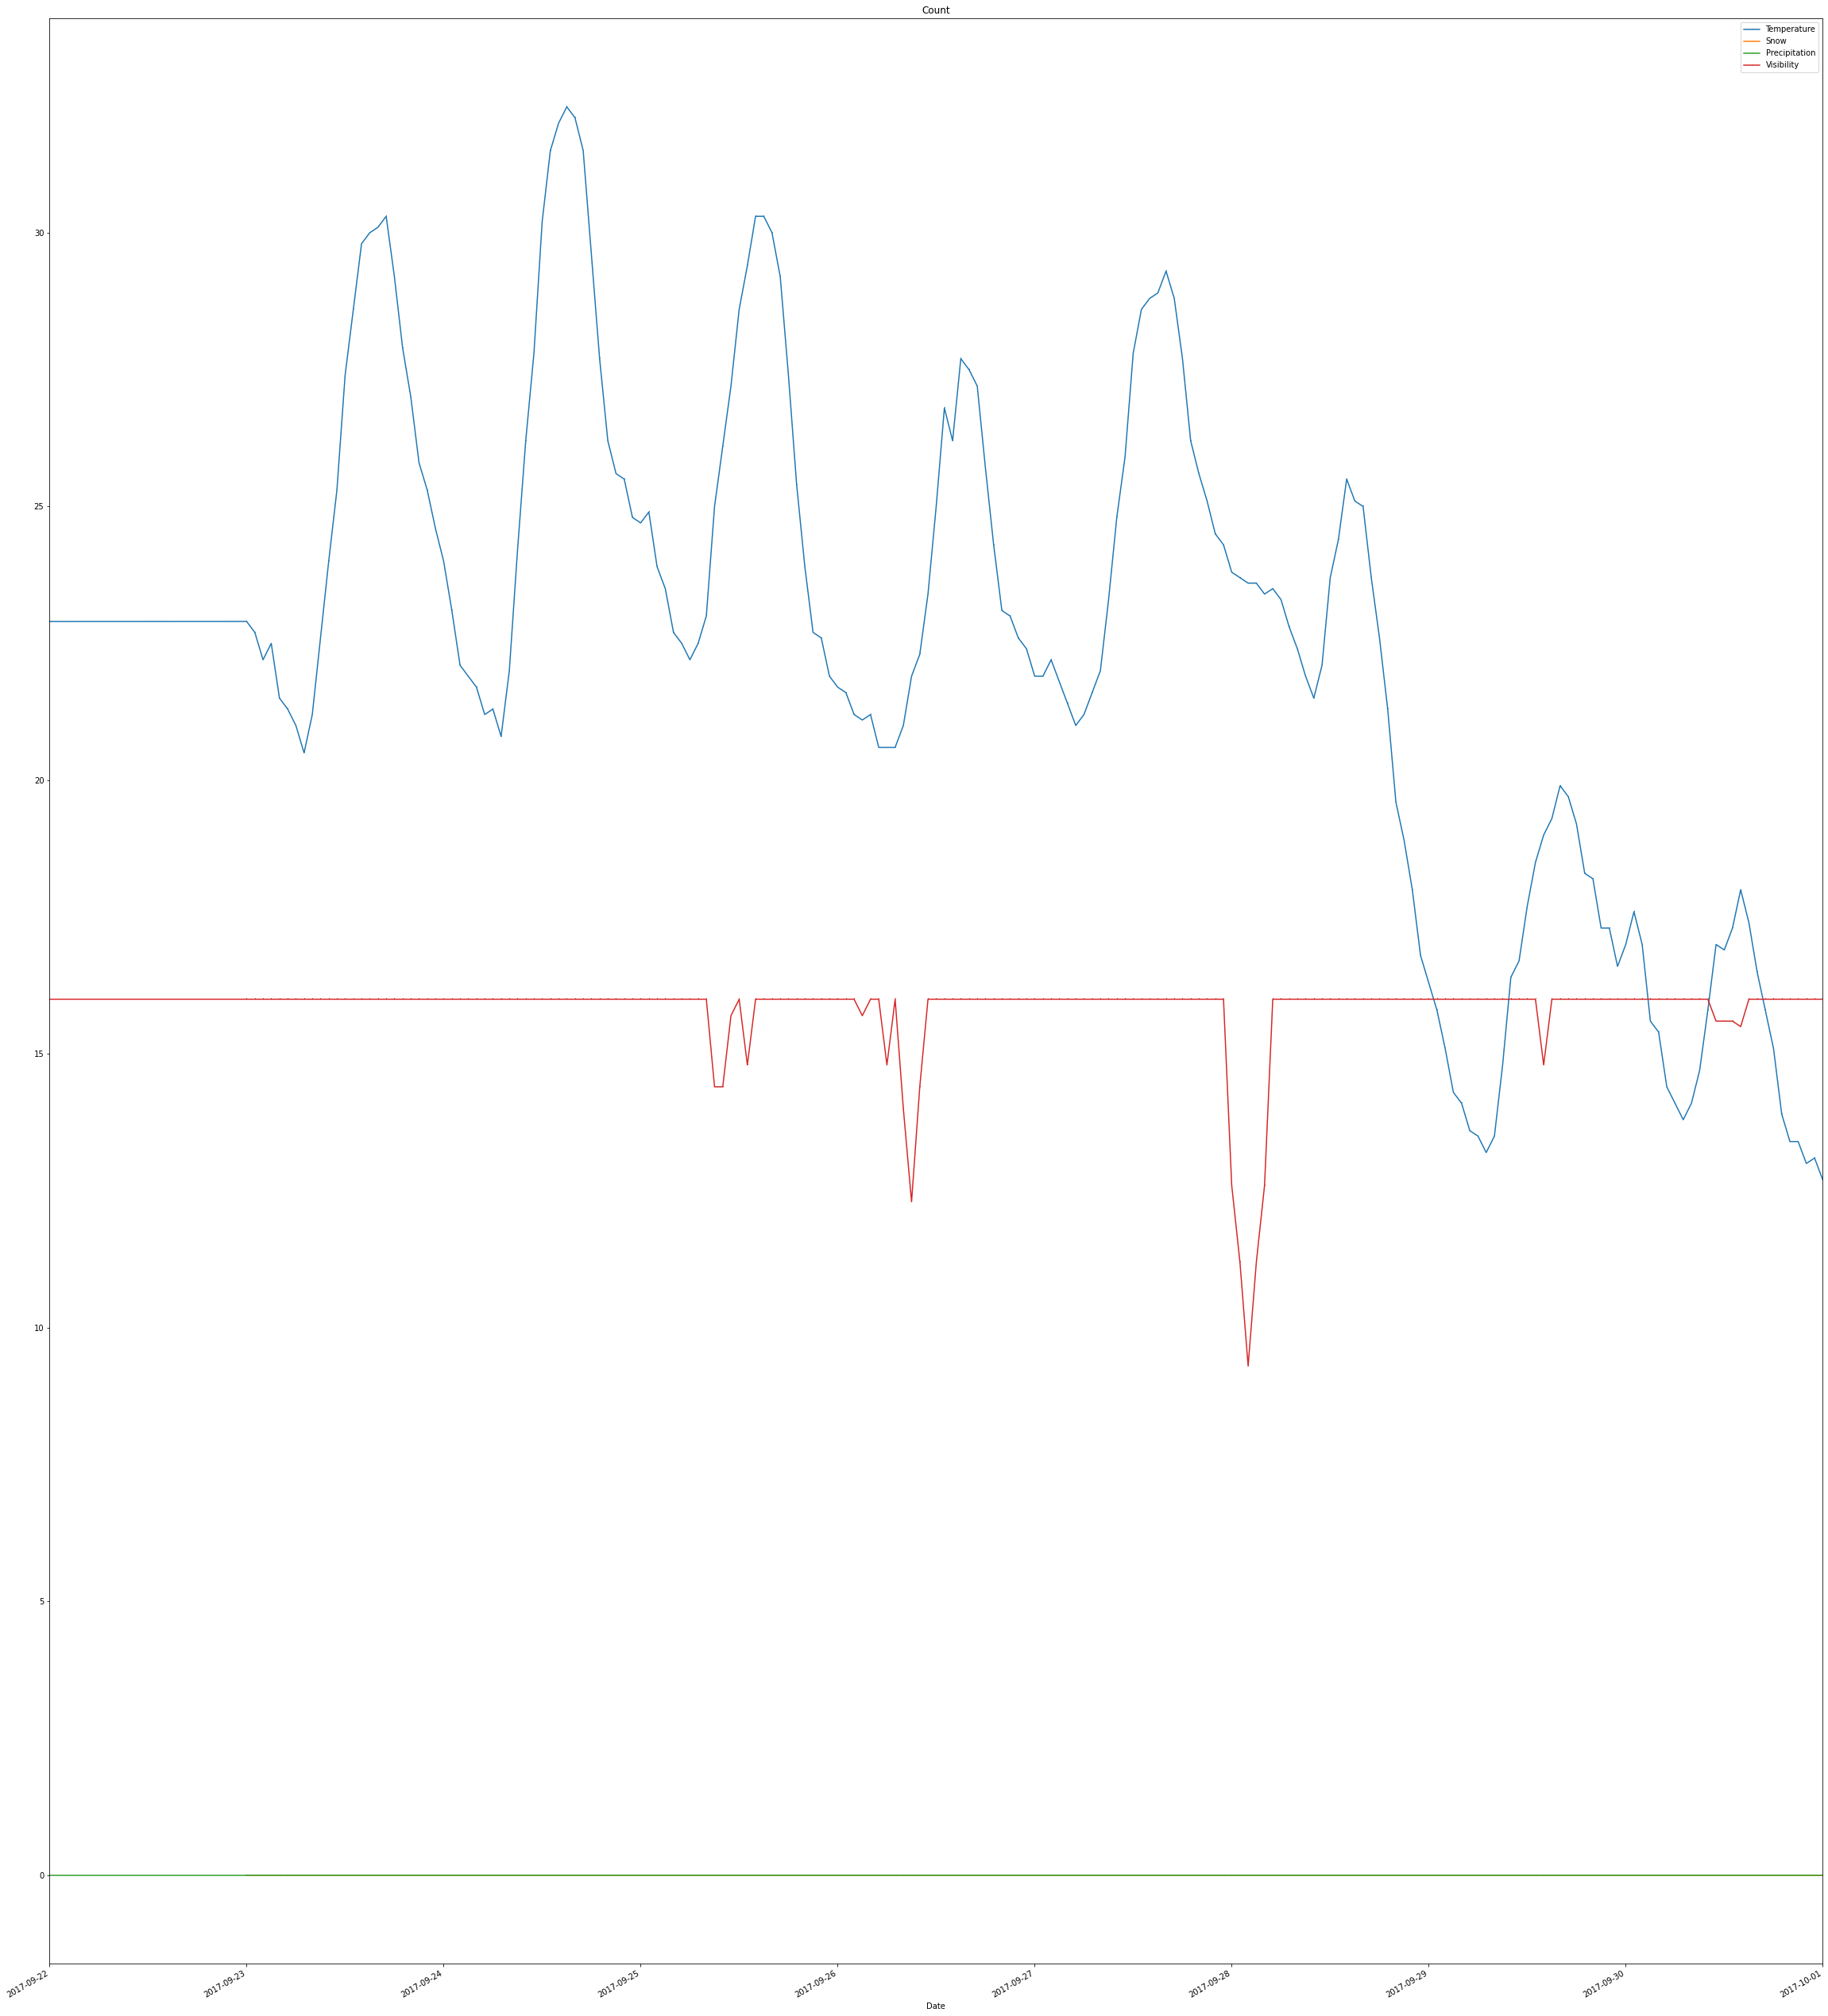

In [36]:
df_test= df_weather.copy(deep=True)
df_test = df_test.set_index('Date')
df_test[['Temperature','Snow','Precipitation','Visibility']].plot(title = 'Count',marker=',', figsize=(40,50)).set_xlim(pd.Timestamp('2014-09-13'), pd.Timestamp('2014-09-21'))
df_test[['Temperature','Snow','Precipitation','Visibility']].plot(title = 'Count',marker=',', figsize=(40,50)).set_xlim(pd.Timestamp('2017-09-22'), pd.Timestamp('2017-10-01'))

Grâce aux premieres visualisation on remarque que la température à une période plutot constante aux cours des deux semaines, ce qui est logique. La visibilité est constante avec parfois des épisodes ou elle baisse. De même, plusieurs précipations ont eu lieu pendant ces deux semaines. Par contre, on ne constate aucune chute de neige en cette période.

Maintenant que les données sont chargées, les deux dataframes vont se merger pour n'en former qu'un. Dans notre cas, nos deux dataframes ont un paramètre en commun, le temps. Il est important de vérifier au préalable qu'il y a le même nombre de lignes dans les deux dataframe. Ensuite, il faut se baser sur le temps pour merger les deux.

In [37]:
df_weather.shape, new_df.shape

((434, 19), (432, 4))

On remarque que les deux dataframes diffèrent de deux lignes, il faudra donc bien faire attention à qu'aucunes données manquent.

In [42]:
#Dataframe final
df_final = pd.merge(df_weather,new_df, on='Date')
df_final.head(5)

Name            Date time  Maximum Temperature  \
0  New York, NY, United States  09/13/2014 00:00:00                 17.0   
1  New York, NY, United States  09/13/2014 01:00:00                 16.8   
2  New York, NY, United States  09/13/2014 02:00:00                 16.2   
3  New York, NY, United States  09/13/2014 03:00:00                 16.0   
4  New York, NY, United States  09/13/2014 04:00:00                 16.0   

   Minimum Temperature  Temperature  Wind Chill  Heat Index  Precipitation  \
0                 17.0         17.0         NaN         NaN            0.0   
1                 16.8         16.8         NaN         NaN            0.0   
2                 16.2         16.2         NaN         NaN            0.0   
3                 16.0         16.0         NaN         NaN            0.0   
4                 16.0         16.0         NaN         NaN            0.0   

   Snow  Snow Depth  ...  Wind Gust  Visibility  Cloud Cover  \
0   NaN         NaN  ...        NaN        16.0         27.9   
1   NaN         NaN  ...        NaN        16.0         27.9   
2   NaN         NaN  ...        NaN        16.0         25.4   
3   NaN         NaN  ...        NaN        16.0         45.9   
4   NaN         NaN  ...        NaN        16.0         90.6   

   Relative Humidity        Conditions  \
0              59.82  Partially cloudy   
1              58.73  Partially cloudy   
2              62.01  Partially cloudy   
3              65.41  Partially cloudy   
4              66.97          Overcast   

                               Contributing Stations                Date  \
0  KNYC (Id=KNYC,6.6KM), NY CITY CENTRAL PARK, NY... 2014-09-13 00:00:00   
1  KNYC (Id=KNYC,6.6KM), NY CITY CENTRAL PARK, NY... 2014-09-13 01:00:00   
2  KNYC (Id=KNYC,6.6KM), NY CITY CENTRAL PARK, NY... 2014-09-13 02:00:00   
3  KNYC (Id=KNYC,6.6KM), NY CITY CENTRAL PARK, NY... 2014-09-13 03:00:00   
4  KNYC (Id=KNYC,6.6KM), NY CITY CENTRAL PARK, NY... 2014-09-13 04:00:00   

   Count Hour  Day  
0  204.0    0    5  
1  177.0    1    5  
2  133.0    2    5  
3  126.0    3    5  
4  141.0    4    5  

[5 rows x 22 columns]

### Prétraitement des données

Il est maintenant important d'avoir des données dites "propres" pour que les modèles de prédictions soient les plus performants.

#### Gérer les valeurs manquantes

In [43]:
df_final.isnull().sum()

Name                       0
Date time                  0
Maximum Temperature        0
Minimum Temperature        0
Temperature                0
Wind Chill               432
Heat Index               395
Precipitation              0
Snow                     216
Snow Depth               216
Wind Speed                 0
Wind Direction             0
Wind Gust                371
Visibility                 0
Cloud Cover                0
Relative Humidity          0
Conditions                 0
Contributing Stations      0
Date                       0
Count                      0
Hour                       0
Day                        0
dtype: int64

La plupart des paramètres qui ont des données manquantes ont peu d'importance dans l'étude. Cependant, la variable d'enneigement 'snow' est quant à elle assez importante.

In [44]:
df_final = df_final.drop('Wind Gust',1)
df_final = df_final.drop('Snow Depth',1)
dff = df_final.drop(['Wind Chill', 'Heat Index'],1) #pas pris en compte pour le moment

/tmp/ipykernel_73645/848235989.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_final = df_final.drop('Wind Gust',1)
/tmp/ipykernel_73645/848235989.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_final = df_final.drop('Snow Depth',1)
/tmp/ipykernel_73645/848235989.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dff = df_final.drop(['Wind Chill', 'Heat Index'],1) #pas pris en compte pour le moment


(17431.0, 17440.0)

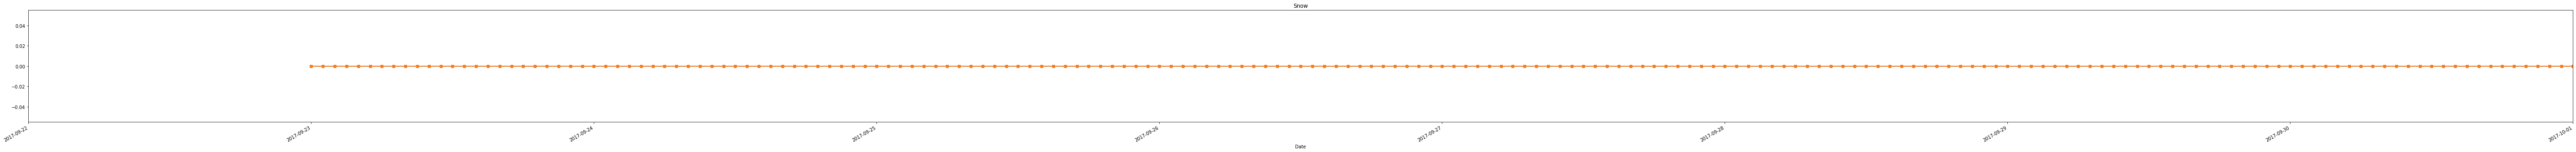

In [51]:
dfsnow_copy = df_test.copy(deep=True)
dfsnow_copy.interpolate(method='linear', inplace=True)
dfsnow_copy['Snow'].plot(color='red', marker='o', linestyle='dotted', figsize=(100, 5)).set_xlim(pd.Timestamp('2014-09-13'), pd.Timestamp('2014-09-21'))
df_test['Snow'].plot(title='Snow', marker='o', figsize=(100, 5)).set_xlim(pd.Timestamp('2014-09-13'), pd.Timestamp('2014-09-21'))

dfsnow_copy['Snow'].plot(color='red', marker='o', linestyle='dotted', figsize=(100, 5)).set_xlim(pd.Timestamp('2017-09-22'), pd.Timestamp('2017-10-01'))
df_test['Snow'].plot(title='Snow', marker='o', figsize=(100, 5)).set_xlim(pd.Timestamp('2017-09-22'), pd.Timestamp('2017-10-01'))


Finalement, toutes les valeurs de Snow sont égales à zéro, nous pouvons donc nous en passer pour notre étude

In [52]:
dff = dff.drop(['Date time','Name','Maximum Temperature','Minimum Temperature','Wind Direction','Conditions','Contributing Stations','Snow'],1)

/tmp/ipykernel_73645/2064138828.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dff = dff.drop(['Date time','Name','Maximum Temperature','Minimum Temperature','Wind Direction','Conditions','Contributing Stations','Snow'],1)


In [53]:
dff.head(4)

Temperature  Precipitation  Wind Speed  Visibility  Cloud Cover  \
0         17.0            0.0        14.6        16.0         27.9   
1         16.8            0.0        16.0        16.0         27.9   
2         16.2            0.0        17.2        16.0         25.4   
3         16.0            0.0        14.9        16.0         45.9   

   Relative Humidity                Date  Count  Hour  Day  
0              59.82 2014-09-13 00:00:00  204.0     0    5  
1              58.73 2014-09-13 01:00:00  177.0     1    5  
2              62.01 2014-09-13 02:00:00  133.0     2    5  
3              65.41 2014-09-13 03:00:00  126.0     3    5

### Exploration et visualisation de la distribution des données

In [54]:
dff.describe()

Temperature  Precipitation  Wind Speed  Visibility  Cloud Cover  \
count   432.000000     432.000000  432.000000  432.000000   432.000000   
mean     19.837037       0.046782    8.683796   15.326157    36.886111   
std       4.521485       0.357218    5.707151    2.216608    35.183883   
min      10.100000       0.000000    0.000000    2.700000     0.000000   
25%      16.400000       0.000000    4.200000   16.000000    10.500000   
50%      19.600000       0.000000    7.900000   16.000000    19.200000   
75%      22.500000       0.000000   12.000000   16.000000    68.800000   
max      32.300000       4.310000   33.800000   16.000000   100.000000   

       Relative Humidity       Count        Hour         Day  
count         432.000000  432.000000  432.000000  432.000000  
mean           62.882963  344.145833   11.500000    3.555556  
std            16.202694  183.301660    6.930212    2.063193  
min            24.630000   48.000000    0.000000    0.000000  
25%            51.182500  166.750000    5.750000    2.000000  
50%            63.320000  352.000000   11.500000    4.000000  
75%            74.225000  507.250000   17.250000    5.000000  
max            95.710000  672.000000   23.000000    6.000000

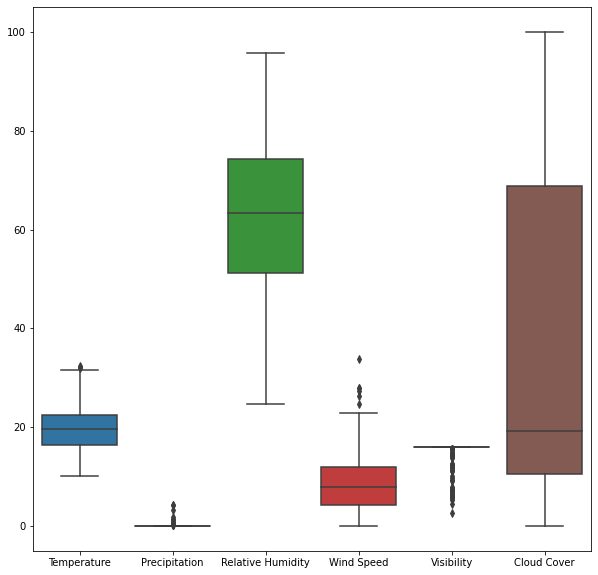

In [55]:
# Possibilité de le visualiser avec des boites à moustache
sns.boxplot(data=dff[['Temperature',
       'Precipitation', 'Relative Humidity', 'Wind Speed', 'Visibility', 'Cloud Cover']])
fig=plt.gcf()
fig.set_size_inches(10,10)

Les données sont étendues, ils ne sont pas du même ordre de grandeur. Il sera peut être utile de normaliser les données lors de la modélisation pour avoir un meilleur résultat.

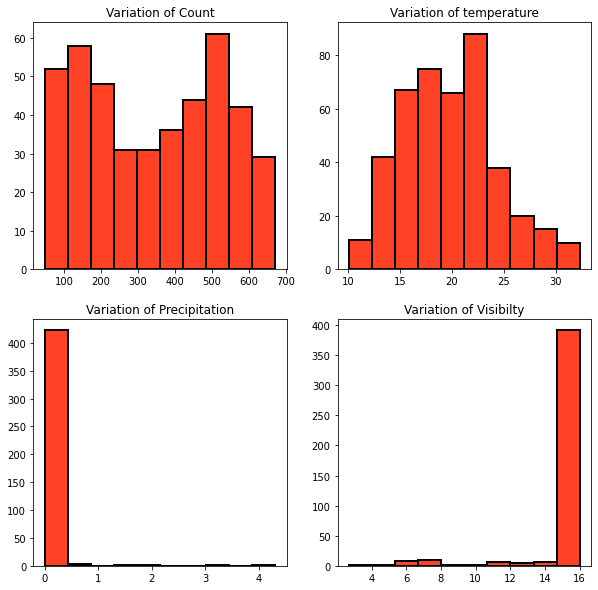

In [58]:
# can also be visualized using histograms for all the continuous variables.
#dff.temp.unique()
fig,axes=plt.subplots(2,2)
axes[0,0].hist(x="Count",data=dff,edgecolor="black",linewidth=2,color='#ff4125')
axes[0,0].set_title("Variation of Count")
axes[0,1].hist(x="Temperature",data=dff,edgecolor="black",linewidth=2,color='#ff4125')
axes[0,1].set_title("Variation of temperature")
axes[1,0].hist(x="Precipitation",data=dff,edgecolor="black",linewidth=2,color='#ff4125')
axes[1,0].set_title("Variation of Precipitation")
axes[1,1].hist(x="Visibility",data=dff,edgecolor="black",linewidth=2,color='#ff4125')
axes[1,1].set_title("Variation of Visibilty")
fig.set_size_inches(10,10)

Les données ne sont pas assez nombreuses pour leurs en déduire une distribution. 

### Etude de corrélation des différents paramètres 

<AxesSubplot:>

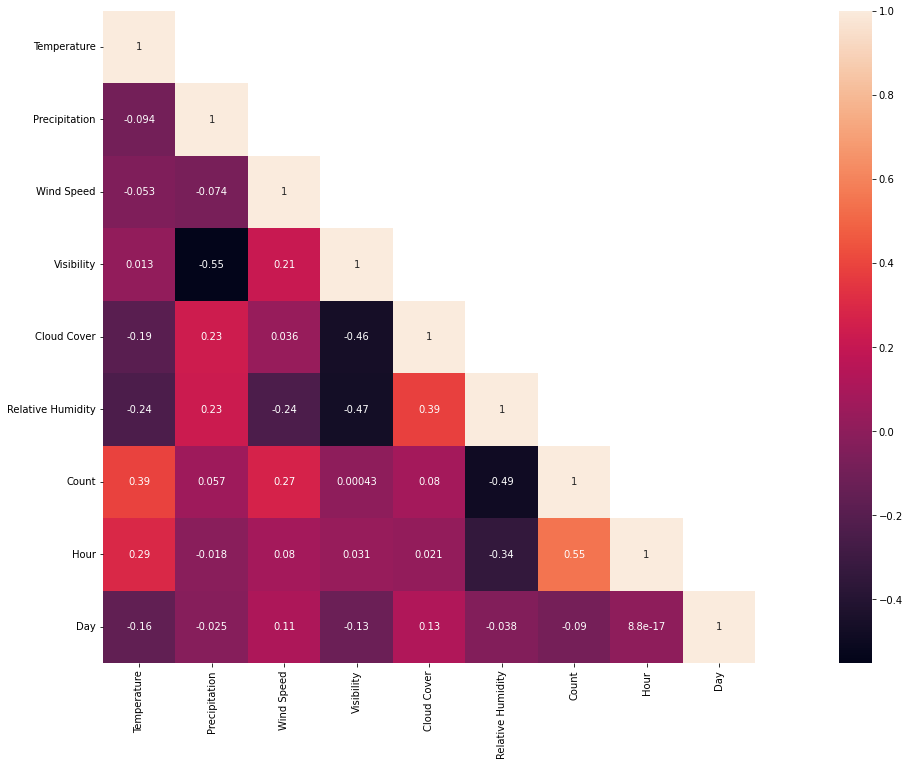

In [59]:
#cMatrice de corrélation
cor_mat= dff[:].corr()
# On créé un masque pour ne montrer que la moitié de la matrice car elle est symétrique
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

#### Hypothèses possibles après analyse du tableau de corrélation

- La relation qu'un paramètre a avec lui - même est de 1, ce qui est logique.

- Comme souhaité, l'heure est un paramètre fortement corrélé au count.

- Finalement, le jour de la semaine n'est pas corrélé au paramètre de notre étude (Count). Il serait surement préférable de différencier jour de travail et week-end pour avoir une véritable corrélation.

- L'humidité est inversement corrélé au paramètre count, il est possible de faire l'hypothèse que les gens sortent moins les jours plus humides.

- La température à un effet important sur le paramètre count, plus il est fais beau, plus les gens prennent leurs voitures et sortent à l'extérieur.

- La vitesse du vent est aussi un paramètre important.

Grâce à cette matrice nous pouvons faire une première conclusion. Les paramètre qui vont le plus influencer notre objectif (Count) sont : Temperature,Wind Speed, Hour, Relative humidity.

Cependant, du au peu de données que nous avons, il est important de prendre du recul vis-à-vis de ces corrélations. En effet, par exemple la variable température a un gros impact sur la variable count car la nuit la temperature est moindre et le flux de véhicule aussi. Il faudrait pouvoir voir sur une plage de données plus importante.

### regression de certaines variables importantes

<AxesSubplot:xlabel='Wind Speed', ylabel='Count'>

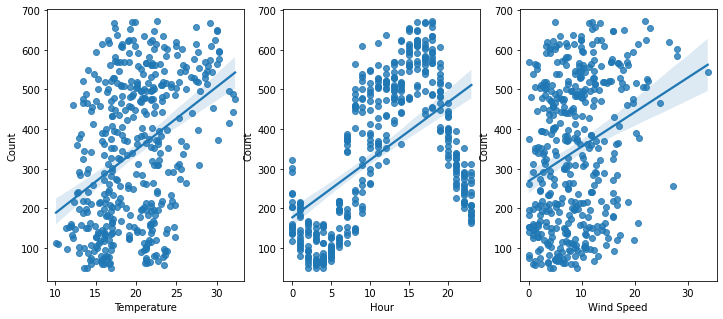

In [61]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="Temperature", y="Count", data=dff, ax=ax1)
sns.regplot(x="Hour", y="Count", data=dff, ax=ax2)
sns.regplot(x="Wind Speed", y="Count", data=dff, ax=ax3)

## Visualisation du paramètre "count" avec ces paramètres les plus corrélés

#### variation avec la température

/home/eliotvg/.local/lib/python3.8/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


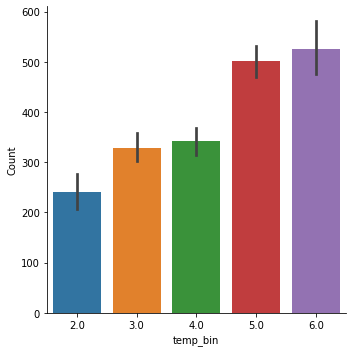

In [20]:
#Variation avec la Temperature
new_df=dff.copy()
new_df.Temperature.describe()
#Nous prenons des intervalles de 5 degré
new_df['temp_bin']=np.floor(new_df['Temperature'])//5
new_df['temp_bin'].unique()
#print(new_df) 
sns.factorplot(x="temp_bin",y="Count",data=new_df,kind='bar')

- Plus la température est élevé plus le flux de circulation est élevé, l'augmentation est plutot linéaire

#### variation avec l'heure

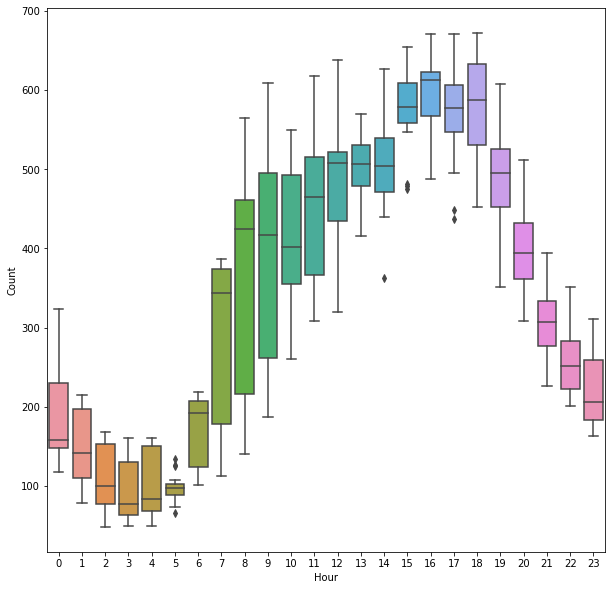

In [22]:
#Variation avec l'heure
sns.boxplot(data=dff,y="Count",x="Hour",orient="v")
fig = plt.gcf()
fig.set_size_inches(10,10)

#### variation avec la vitesse du vent

/home/eliotvg/.local/lib/python3.8/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


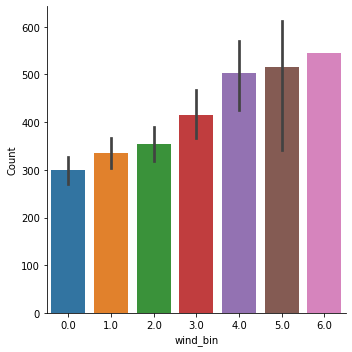

In [23]:
#Variation avec la vitesse du vent
new_df=dff.copy()
new_df.Temperature.describe()
#Nous prenons des intervalles de 5 
new_df['wind_bin']=np.floor(new_df['Wind Speed'])//5
new_df['wind_bin'].unique()
#print(new_df) 
sns.factorplot(x="wind_bin",y="Count",data=new_df,kind='bar')

- Plus il y a de vent, plus les usagers prennent leurs voitures. Cela semble plutot logique.

#### variation avec l'heure en groupant par jour de la semaine

[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Users Count'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across Weekdays'),
 None]

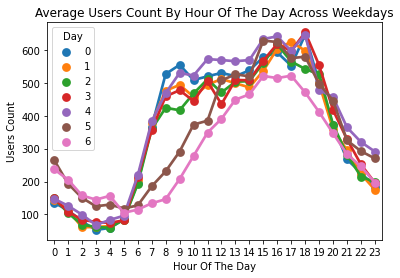

In [64]:
fig,ax1= plt.subplots(nrows=1)
#fig.set_size_inches(12,20)
# Daily Aggregation by day of the week
hourAggregated = pd.DataFrame(new_df.groupby(["Hour","Day"],sort=True)["Count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["Hour"], y=hourAggregated["Count"], hue=hourAggregated["Day"],
              data=hourAggregated, join=True, ax=ax1)   # hue_order=hueOrder
ax1.set(xlabel='Hour Of The Day', ylabel='Users Count', title="Average Users Count By Hour Of The Day Across Weekdays",
        label='big')

- Sur ce graphique, nous remarquons véritablement que le samedi et surtout le dimanche, il y a une chute du trafic routier.

## Preparation des données pour les différents modèles

Afin d'avoir une prévision optimale, il est important de filtrer les données. En effet, des valeurs aberrantes, du à un mauvais capteur ou une excpetion, peuvent pertuber les algorithmes de prédiction.

In [67]:
#on enlève les valeurs extrèmes
df_wo = dff[np.abs(dff["Count"] - dff["Count"].mean())<=(3*dff["Count"].std())] 
print ("Shape Of The Before Ouliers: ", dff.shape)
print ("Shape Of The After Ouliers: ", df_wo.shape)

Shape Of The Before Ouliers:  (432, 10)
Shape Of The After Ouliers:  (432, 10)


On remarque que notre dataset ne contient aucune valeur extrème.

In [68]:
dff.columns.to_series().groupby(dff.dtypes).groups

{float64: ['Temperature', 'Precipitation', 'Wind Speed', 'Visibility', 'Cloud Cover', 'Relative Humidity', 'Count'], datetime64[ns]: ['Date'], int64: ['Hour', 'Day']}

### Choix des input/ output
L'objectif de notre étude est de connaitre le volume du traffic en fonction de différents paraèmtres. L'output est donc le paramètre "Count". Les paramètres en input sont : Temperature,Precipitation, Wind Speed, Visibility, Cloud Cover, Hour, Day.

In [69]:
#Choix des input/output
X = dff.drop(['Count','Date','Precipitation','Visibility','Cloud Cover'],axis=1)
y = dff['Count']
#print(X,y)
x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=42)
print(x_train)

     Temperature  Wind Speed  Relative Humidity  Hour  Day
3           16.0        14.9              65.41     3    5
18          17.4         7.1              92.32    18    5
137         23.5         4.0              35.99    17    3
60          19.4         7.4              37.98    12    0
209         23.9         4.0              73.62    17    6
..           ...         ...                ...   ...  ...
71          17.2         7.9              66.14    23    0
106         17.4         8.0              51.44    10    2
270         22.2         0.0              80.89     6    0
348         23.7        20.3              41.51    12    3
102         14.0         5.7              74.13     6    2

[324 rows x 5 columns]


## Entraiement de différents modèles de régression

In [70]:
# Create a dictionnary of 5 different regression models
# careful : some regression models predict negative values, this is a problem !
models ={'RandomForestRegressor' : RandomForestRegressor(),
         'Ridge' : Ridge(),
         'AdaBoostRegressor': AdaBoostRegressor(),
         'BaggingRegressor' : BaggingRegressor() ,
         'GradientBoostingRegressor' : GradientBoostingRegressor(),
         'SVR' : SVR(),   # predict some negative values - pb with msle scoring
         'KNeighborsRegressor' : KNeighborsRegressor()
        }
model_names = list(models.keys())
# to store the list of scoring (mean square log error on the count output)
rmsle=[]
for model_name, model in models.items():
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    print(model_name)
    # print(y_pred)
    mse = np.sqrt(mean_squared_error(y_pred,y_test))
    # msle = np.sqrt(mean_squared_log_error(y_pred,y_test))   # pb avec des y_pred négatifs avec SVR, Ridge ...
    print('Modelling Algo : ', model_name,' - RMSE = ', mse)
    rmsle.append(mse)
d={'Modelling Algo':model_names,'RMSLE':rmsle}

RandomForestRegressor
Modelling Algo :  RandomForestRegressor  - RMSE =  41.72777133907257
Ridge
Modelling Algo :  Ridge  - RMSE =  146.71444562793806
AdaBoostRegressor
Modelling Algo :  AdaBoostRegressor  - RMSE =  59.34167306989209
BaggingRegressor
Modelling Algo :  BaggingRegressor  - RMSE =  45.92306468834991
GradientBoostingRegressor
Modelling Algo :  GradientBoostingRegressor  - RMSE =  46.06577583153838
SVR
Modelling Algo :  SVR  - RMSE =  170.44285909817836
KNeighborsRegressor
Modelling Algo :  KNeighborsRegressor  - RMSE =  103.45987950247509


/home/eliotvg/.local/lib/python3.8/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/eliotvg/.local/lib/python3.8/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


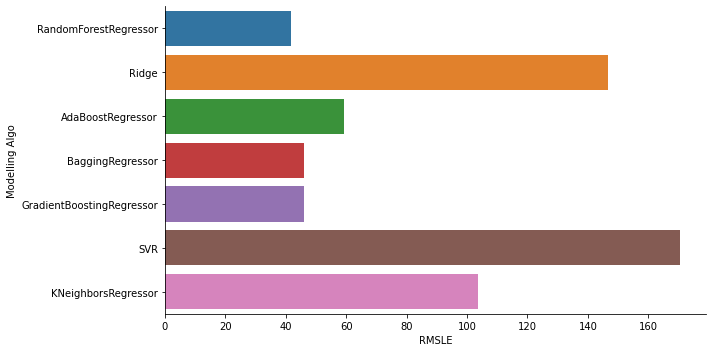

In [71]:
# on met sous forme de dataframe pour pouvoir afficher graphiquement les résultats
rmsle_frame=pd.DataFrame(d)
rmsle_frame
sns.factorplot(y='Modelling Algo',x='RMSLE',data=rmsle_frame,kind='bar',size=5,aspect=2)



modèles choisies : le plus petit RMSE -> RandomForestRegressor


Cet indice fournit une indication par rapport à la dispersion ou la variabilité de la qualité de la prédiction.

## Optimisation du modèle choisi

In [72]:
#Optimisation du modèle choisie
# number of tests for this model that optimize a sequence of decision trees
no_of_test = [500]
# the grid of alternative parameters and their values to evaluate
params_dict = {'n_estimators':no_of_test, 'n_jobs':[-1], 'max_features':["auto",'sqrt','log2']}
# We make the parametring Random Forest model (grid) and train it
grid_rf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=params_dict, scoring='neg_mean_squared_log_error')
grid_rf.fit(x_train, y_train)
y_pred = grid_rf.predict(x_test)
# Give the results - best values for parameters
print("Best parameter(s): {}".format(grid_rf.best_params_))
# The average score
# print("Average score for best parameters: {}".format(grid_rf.best_score_))
RMSE = np.sqrt(mean_squared_error(y_pred, y_test))
print('RMSE = ', RMSE)
print('RMSLE = ', np.sqrt(mean_squared_log_error(y_pred, y_test)))

Best parameter(s): {'max_features': 'auto', 'n_estimators': 500, 'n_jobs': -1}
RMSE =  41.08267775361542
RMSLE =  0.10914466111671638


- Meme avec optimisation, le résultats est à peu près le même. Il faut trouver une nouvelle solution pour améliorer le score.

In [73]:
RandomForestRegressor().fit(x_train,y_train)
y_pred = model.predict(x_test)
print("Random Forest Prediction : \n")
erreur = y_test - y_pred
print(erreur)
moy_erreur =sum(abs(erreur))/len(erreur)
print(sum(abs(erreur))/len(erreur))

Random Forest Prediction : 

424     13.0
75      -4.4
180     64.0
30      -5.8
392     77.6
       ...  
272    331.8
16     119.4
400     94.6
131     30.8
361    -34.8
Name: Count, Length: 108, dtype: float64
76.56296296296294


Notre régression se trompe en moyenne de 76,5 véhicule sur ces prédictions.

### Conclusion

Notre régression se trompe en moyenne de 76 véhicule sur la prédiction de nombre de véhicule, à une certaine heure. L'erreur est trop importante, il faut essayer de travailler sur les paramètres pour améliorer notre prédiction.

## Optimisation de la prédiction

### Prédiction avec données normalisées

Comme les donnees sont à des echelles differentes, il est préférable de normaliser
les données pour que les modèles de Machine Learning soient plus performants. Après
l’entrainement de données, on est toujours obliger de reconvertir le résultat de prediction
pour qu’il puisse garder les memes  ́echelles que les donnees originales.

<AxesSubplot:>

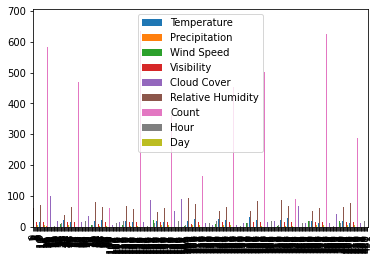

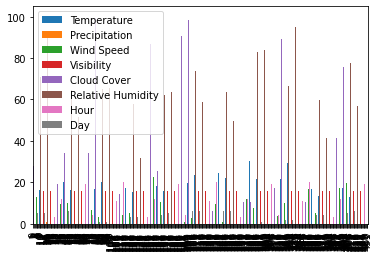

In [75]:
normal = dff.drop('Date',axis=1)
normal.plot(kind='bar')
normal2 = dff.drop(['Date','Count'],axis=1)
normal2.plot(kind='bar')

D'après la visualisation des données ci dessus, on remarque que les données sont très réparties et qu'elle n'ont pas la même échelle. Ici, il est pertinent de de normaliser les donnees. Il y a plusieurs possibilités pour normaliser les données.

#### Méthode de la mise à l'échelle du maximum absolue

La mise à l'échelle du maximum absolue redimensionne chaque caractéristique entre -1 et 1 en divisant chaque observation par sa valeur absolue maximale.

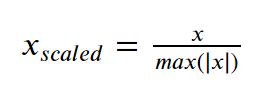

In [76]:
# copy the data
df_max_scaled = dff.drop('Date',axis=1).copy()
  
# apply normalization techniques
for column in df_max_scaled.columns:
    df_max_scaled[column] = df_max_scaled[column]  / df_max_scaled[column].abs().max()
      
# view normalized data
display(df_max_scaled)

Temperature  Precipitation  Wind Speed  Visibility  Cloud Cover  \
0       0.526316            0.0    0.431953         1.0        0.279   
1       0.520124            0.0    0.473373         1.0        0.279   
2       0.501548            0.0    0.508876         1.0        0.254   
3       0.495356            0.0    0.440828         1.0        0.459   
4       0.495356            0.0    0.381657         1.0        0.906   
..           ...            ...         ...         ...          ...   
427     0.566563            0.0    0.147929         1.0        0.044   
428     0.547988            0.0    0.088757         1.0        0.000   
429     0.526316            0.0    0.118343         1.0        0.000   
430     0.517028            0.0    0.201183         1.0        0.000   
431     0.507740            0.0    0.224852         1.0        0.000   

     Relative Humidity     Count      Hour       Day  
0             0.625013  0.303571  0.000000  0.833333  
1             0.613624  0.263393  0.043478  0.833333  
2             0.647895  0.197917  0.086957  0.833333  
3             0.683419  0.187500  0.130435  0.833333  
4             0.699718  0.209821  0.173913  0.833333  
..                 ...       ...       ...       ...  
427           0.467767  0.604167  0.826087  1.000000  
428           0.481559  0.583333  0.869565  1.000000  
429           0.482917  0.438988  0.913043  1.000000  
430           0.465678  0.389881  0.956522  1.000000  
431           0.502142  0.270833  1.000000  1.000000  

[432 rows x 9 columns]

<AxesSubplot:>

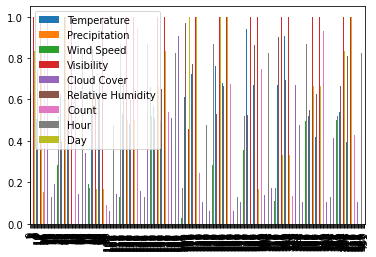

In [77]:
df_max_scaled.plot(kind = 'bar')

#### Méthode de la mise à l'échelle min-max

L'approche min-max (souvent appelée normalisation) redimensionne la caractéristique à une plage dure et rapide de [0,1] en soustrayant la valeur minimale de la caractéristique puis en divisant par la plage. 

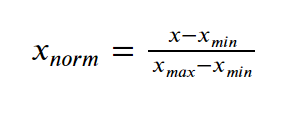

In [78]:
# copy the data
df_min_max_scaled = dff.drop('Date',axis=1).copy()
  
# apply normalization techniques
for column in df_min_max_scaled.columns:
    df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())    
  
# view normalized data
print(df_min_max_scaled)

     Temperature  Precipitation  Wind Speed  Visibility  Cloud Cover  \
0       0.310811            0.0    0.431953         1.0        0.279   
1       0.301802            0.0    0.473373         1.0        0.279   
2       0.274775            0.0    0.508876         1.0        0.254   
3       0.265766            0.0    0.440828         1.0        0.459   
4       0.265766            0.0    0.381657         1.0        0.906   
..           ...            ...         ...         ...          ...   
427     0.369369            0.0    0.147929         1.0        0.044   
428     0.342342            0.0    0.088757         1.0        0.000   
429     0.310811            0.0    0.118343         1.0        0.000   
430     0.297297            0.0    0.201183         1.0        0.000   
431     0.283784            0.0    0.224852         1.0        0.000   

     Relative Humidity     Count      Hour       Day  
0             0.495076  0.250000  0.000000  0.833333  
1             0.479741  0

<AxesSubplot:>

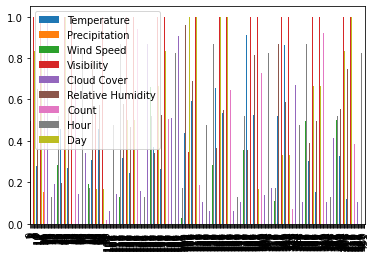

In [79]:
df_min_max_scaled.plot(kind = 'bar')

#### Méthode de la mise à l'échelle Z-score

La méthode du Z-score (souvent appelée standardisation) transforme l'information en distribution avec une moyenne de 0 et un écart typique de 1. Chaque valeur normalisée est calculée en soustrayant la moyenne de la caractéristique correspondante puis en divisant par l'écart de qualité.

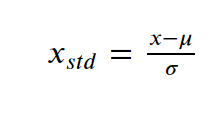

In [80]:
# copy the data
df_z_scaled = dff.drop('Date',axis=1).copy()
  
# apply normalization techniques
for column in df_z_scaled.columns:
    df_z_scaled[column] = (df_z_scaled[column] -
                           df_z_scaled[column].mean()) / df_z_scaled[column].std()    
  
# view normalized data   
display(df_z_scaled)

Temperature  Precipitation  Wind Speed  Visibility  Cloud Cover  \
0      -0.627457      -0.130963    1.036630    0.303997    -0.255404   
1      -0.671690      -0.130963    1.281936    0.303997    -0.255404   
2      -0.804390      -0.130963    1.492199    0.303997    -0.326459   
3      -0.848623      -0.130963    1.089196    0.303997     0.256194   
4      -0.848623      -0.130963    0.738758    0.303997     1.526662   
..           ...            ...         ...         ...          ...   
427    -0.339941      -0.130963   -0.645470    0.303997    -0.923324   
428    -0.472641      -0.130963   -0.995908    0.303997    -1.048381   
429    -0.627457      -0.130963   -0.820689    0.303997    -1.048381   
430    -0.693807      -0.130963   -0.330076    0.303997    -1.048381   
431    -0.760157      -0.130963   -0.189901    0.303997    -1.048381   

     Relative Humidity     Count      Hour       Day  
0            -0.189040 -0.764564 -1.659401  0.700101  
1            -0.256313 -0.911862 -1.515105  0.700101  
2            -0.053878 -1.151904 -1.370809  0.700101  
3             0.155964 -1.190092 -1.226514  0.700101  
4             0.252244 -1.108260 -1.082218  0.700101  
..                 ...       ...       ...       ...  
427          -1.117898  0.337445  1.082218  1.184787  
428          -1.036430  0.261068  1.226514  1.184787  
429          -1.028407 -0.268115  1.370809  1.184787  
430          -1.130242 -0.448146  1.515105  1.184787  
431          -0.914846 -0.884585  1.659401  1.184787  

[432 rows x 9 columns]

<AxesSubplot:>

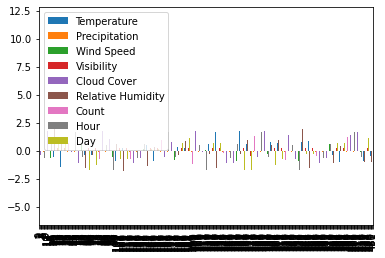

In [81]:
df_z_scaled.plot(kind='bar')

D'après la visualisation, la méthode Z-score semble être la plus efficace. Pour vraiment remarqué l'éfficacité de la standardisation, nous pouvons entrainer le modèle choisi pour voir si une amélioration est remarqué.

In [82]:
X = df_z_scaled.drop(['Count','Precipitation','Visibility','Cloud Cover'],axis=1)
y = df_z_scaled['Count']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Create a dictionnary of 5 different regression models
# careful : some regression models predict negative values, this is a problem !
models ={'RandomForestRegressor' : RandomForestRegressor(),
         'Ridge' : Ridge(),
         'AdaBoostRegressor': AdaBoostRegressor(),
         'BaggingRegressor' : BaggingRegressor() ,
         'GradientBoostingRegressor' : GradientBoostingRegressor(),
         'SVR' : SVR(),   # predict some negative values - pb with msle scoring
         'KNeighborsRegressor' : KNeighborsRegressor()
        }
model_names = list(models.keys())
# to store the list of scoring (mean square log error on the count output)
rmsle=[]
for model_name, model in models.items():
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    print(model_name)
    # print(y_pred)
    mse = np.sqrt(mean_squared_error(y_pred,y_test))
    # msle = np.sqrt(mean_squared_log_error(y_pred,y_test))   # pb avec des y_pred négatifs avec SVR, Ridge ...
    print('Modelling Algo : ', model_name,' - RMSE = ', mse)
    rmsle.append(mse)
d={'Modelling Algo':model_names,'RMSLE':rmsle}

RandomForestRegressor
Modelling Algo :  RandomForestRegressor  - RMSE =  0.22592848405760085
Ridge
Modelling Algo :  Ridge  - RMSE =  0.8002272423624041
AdaBoostRegressor
Modelling Algo :  AdaBoostRegressor  - RMSE =  0.3329386743601237
BaggingRegressor
Modelling Algo :  BaggingRegressor  - RMSE =  0.2357564627340467
GradientBoostingRegressor
Modelling Algo :  GradientBoostingRegressor  - RMSE =  0.2512801305474543
SVR
Modelling Algo :  SVR  - RMSE =  0.473746676887573
KNeighborsRegressor
Modelling Algo :  KNeighborsRegressor  - RMSE =  0.5333071379481371


/home/eliotvg/.local/lib/python3.8/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/eliotvg/.local/lib/python3.8/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


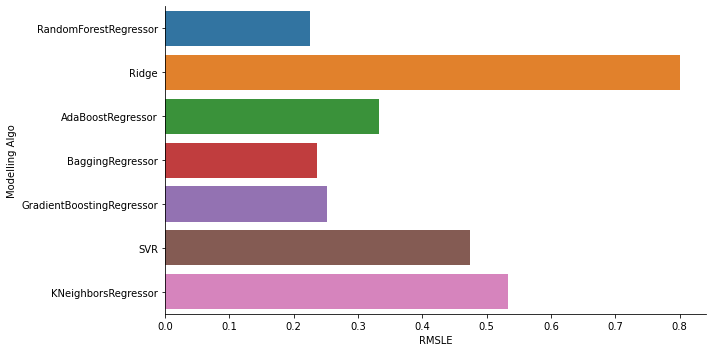

In [85]:
# on met sous forme de dataframe pour pouvoir afficher graphiquement les résultats
rmsle_frame=pd.DataFrame(d)
rmsle_frame
sns.factorplot(y='Modelling Algo',x='RMSLE',data=rmsle_frame,kind='bar',size=5,aspect=2)

In [86]:
RandomForestRegressor().fit(x_train,y_train)
y_pred = model.predict(x_test)
#print("Random Forest Prediction : \n")
erreur = y_test - y_pred
#print(erreur)
moy_erreur =sum(abs(erreur))/len(erreur)
print(sum(abs(erreur))/len(erreur))

0.39717973023496606


Il faut maintenant faire l'inverse de la normalisation pour avoir l'échelle correcte des données.

### Sélection de caractéristiques

La séléction de caractéristiques consiste à trouver un sous-sensemble de variables pertinentes. C'est-à-dire que l'on cherche à minimiser la perte d'information venant de la suppression de toutes les autres variables.

La sélection de caractéristiques est une technique dans laquelle nous choisissons les caractéristiques de nos données qui contribuent le plus à la variable cible. En d'autres termes, nous choisissons les meilleurs prédicteurs pour la variable cible.

In [87]:
print(dff.head(2))

   Temperature  Precipitation  Wind Speed  Visibility  Cloud Cover  \
0         17.0            0.0        14.6        16.0         27.9   
1         16.8            0.0        16.0        16.0         27.9   

   Relative Humidity                Date  Count  Hour  Day  
0              59.82 2014-09-13 00:00:00  204.0     0    5  
1              58.73 2014-09-13 01:00:00  177.0     1    5  


In [88]:
X_reg= dff.drop(['Date','Count'], axis=1)
y_reg=dff['Count']

In [89]:
from sklearn.feature_selection import SelectKBest, chi2, f_regression


# Create the object for SelectKBest and fit and transform the regression data
X_reg_new=SelectKBest(score_func=f_regression, k=3).fit_transform(X_reg,y_reg)
# Check the newly created variable for top two best features
print(X_reg_new[:5])

[[17.   59.82  0.  ]
 [16.8  58.73  1.  ]
 [16.2  62.01  2.  ]
 [16.   65.41  3.  ]
 [16.   66.97  4.  ]]


In [90]:
# Compare the newly created values with feature set values to know the selected features
print(X_reg.head())

   Temperature  Precipitation  Wind Speed  Visibility  Cloud Cover  \
0         17.0            0.0        14.6        16.0         27.9   
1         16.8            0.0        16.0        16.0         27.9   
2         16.2            0.0        17.2        16.0         25.4   
3         16.0            0.0        14.9        16.0         45.9   
4         16.0            0.0        12.9        16.0         90.6   

   Relative Humidity  Hour  Day  
0              59.82     0    5  
1              58.73     1    5  
2              62.01     2    5  
3              65.41     3    5  
4              66.97     4    5  


D'apès nos observation les trois meilleures caractéristiques sont l'humidité, l'heure et la température. Cela comfirme notre tableau de corrélation vu plus haut.

In [91]:
#X = df_z_scaled.drop(['Count','Precipitation','Visibility','Cloud Cover','Wind Speed','Day'],axis=1)
#y = df_z_scaled['Count']

#Choix des input/output
X = dff.drop(['Count','Date','Precipitation','Visibility','Cloud Cover','Wind Speed','Day'],axis=1)
y = dff['Count']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Create a dictionnary of 5 different regression models
# careful : some regression models predict negative values, this is a problem !
models ={'RandomForestRegressor' : RandomForestRegressor(),
         'Ridge' : Ridge(),
         'AdaBoostRegressor': AdaBoostRegressor(),
         'BaggingRegressor' : BaggingRegressor() ,
         'GradientBoostingRegressor' : GradientBoostingRegressor(),
         'SVR' : SVR(),   # predict some negative values - pb with msle scoring
         'KNeighborsRegressor' : KNeighborsRegressor()
        }
model_names = list(models.keys())
# to store the list of scoring (mean square log error on the count output)
rmsle=[]
for model_name, model in models.items():
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    print(model_name)
    # print(y_pred)
    mse = np.sqrt(mean_squared_error(y_pred,y_test))
    # msle = np.sqrt(mean_squared_log_error(y_pred,y_test))   # pb avec des y_pred négatifs avec SVR, Ridge ...
    print('Modelling Algo : ', model_name,' - RMSE = ', mse)
    rmsle.append(mse)
d={'Modelling Algo':model_names,'RMSLE':rmsle}

RandomForestRegressor
Modelling Algo :  RandomForestRegressor  - RMSE =  78.04109913182735
Ridge
Modelling Algo :  Ridge  - RMSE =  153.34879945566664
AdaBoostRegressor
Modelling Algo :  AdaBoostRegressor  - RMSE =  83.91755497487706
BaggingRegressor
Modelling Algo :  BaggingRegressor  - RMSE =  80.6673461863023
GradientBoostingRegressor
Modelling Algo :  GradientBoostingRegressor  - RMSE =  86.40759110901757
SVR
Modelling Algo :  SVR  - RMSE =  168.3544221134307
KNeighborsRegressor
Modelling Algo :  KNeighborsRegressor  - RMSE =  93.2092329713699


In [93]:
RandomForestRegressor().fit(x_train,y_train)
y_pred = model.predict(x_test)
print("Random Forest Prediction : \n")
erreur = y_test - y_pred
print(erreur)
moy_erreur =sum(abs(erreur))/len(erreur)
print(sum(abs(erreur))/len(erreur))


Random Forest Prediction : 

424    -94.2
75     -18.0
180     82.0
30     -55.4
392     -0.4
       ...  
272    271.4
16     119.4
400     40.8
131     -2.6
361    -35.8
Name: Count, Length: 108, dtype: float64
74.33518518518518


#### Conclusion

L'erreur à baisser de deux véhicules en choissisant mieux les paramètres de prédictions.

## Prédiction heure par heure

L'objectif de l'étude maintenant est d'évaluer l'erreur heure par heure. 

In [94]:
#RandomForestRegressor().fit(x_train,y_train)
x_test_1 = x_test.copy()
#x_test_1.loc[x_test_1["Hour"]!=1,'Hour']=0
x_test_1 =x_test_1[x_test_1["Hour"]==16]
#y_pred_1 = model.predict(x_test_1)
#print(x_test)
#print(x_test_1)
#print("Random Forest Prediction : \n")
#erreur = y_test - y_pred_1
#print(erreur)
dff_0=dff[dff['Hour']==0]
dff_1=dff[dff['Hour']==1]
dff_2=dff[dff['Hour']==2]
dff_3=dff[dff['Hour']==3]
dff_4=dff[dff['Hour']==4]
dff_5=dff[dff['Hour']==5]
dff_6=dff[dff['Hour']==6]
dff_7=dff[dff['Hour']==7]
dff_8=dff[dff['Hour']==8]
dff_9=dff[dff['Hour']==9]
dff_10=dff[dff['Hour']==10]
dff_11=dff[dff['Hour']==11]
dff_12=dff[dff['Hour']==12]
dff_13=dff[dff['Hour']==13]
dff_14=dff[dff['Hour']==14]
dff_15=dff[dff['Hour']==15]
dff_16=dff[dff['Hour']==16]
dff_17=dff[dff['Hour']==17]
dff_18=dff[dff['Hour']==18]
dff_19=dff[dff['Hour']==19]
dff_20=dff[dff['Hour']==20]
dff_21=dff[dff['Hour']==21]
dff_22=dff[dff['Hour']==22]
dff_23=dff[dff['Hour']==23]
dff_hour = []
dff_hour.append((dff_0,dff_1,dff_2,dff_3,dff_4,dff_5,dff_6,dff_7,dff_8,dff_10,dff_11,dff_12,dff_13,dff_14,dff_15,dff_16,dff_17,dff_18,dff_19,dff_20,dff_21,dff_22,dff_23))
print(dff_hour[0][1])

     Temperature  Precipitation  Wind Speed  Visibility  Cloud Cover  \
1           16.8            0.0        16.0        16.0         27.9   
25          15.4            0.0         6.1        16.0          0.0   
49          15.2            0.0         8.8        16.0          6.1   
73          17.2            0.0         3.7        16.0         35.9   
97          16.9            0.0         7.7        16.0         10.5   
121         16.4            0.0         5.7        16.0          0.0   
145         16.9            0.0        14.6        16.0          4.4   
169         16.0            0.0         8.7        16.0         14.1   
193         21.5            0.0         0.0        16.0        100.0   
217         22.7            0.0        11.6        16.0         10.5   
241         23.1            0.0         1.2        16.0          0.0   
265         24.9            0.0         1.7        16.0          0.0   
289         21.6            0.0         2.9        16.0         

In [95]:
dict_erreur = {}
"""
for i in range(24):
    #Choix des input/output
    string="dff_"+str(i)
    string=pd.DataFrame(string)
    X = string.drop(['Count','Date','Precipitation','Visibility','Cloud Cover'],axis=1)
    y = string['Count']
    x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42)
    #X = dff_i.drop(['Count','Date','Precipitation','Visibility','Cloud Cover'],axis=1)
    #y = dff['Count']
    #print(X,y)
    #x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42)
    RandomForestRegressor().fit(x_train,y_train)
    y_pred = model.predict(x_test)
    #print("Random Forest Prediction : \n")
    erreur = y_test - y_pred
    #print(erreur)
    moy_erreur =sum(abs(erreur))/len(erreur)
    #print(sum(abs(erreur))/len(erreur))
    erreur.append(moy_erreur)
    
print(erreur)
"""
for i in range(len(dff_hour[0])):
    dff_h = dff_hour[0]
    #print(dff_h[i])
    X = dff_h[i].drop(['Count','Date','Precipitation','Visibility','Cloud Cover','Wind Speed','Day'],axis=1)
    y = dff_h[i]['Count']
    #print(X)
    #print(y)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)
    #print(x_train)
    #print(y_train)
    #print(x_test)
    #print(y_test)

    #X = dff_i.drop(['Count','Date','Precipitation','Visibility','Cloud Cover'],axis=1)
    #y = dff['Count']
    #print(X,y)
    #x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42)
    RandomForestRegressor().fit(x_train,y_train)
    y_pred = model.predict(x_test)
    #print("Random Forest Prediction : \n")
    #print("______________")
    #print(y_pred)
    #print("___________")
    erreur = y_test - y_pred
    #print(erreur)
    moy_erreur =sum(abs(erreur))/len(erreur)
    #print(sum(abs(erreur))/len(erreur))
    min_dff = min(dff_h[i]["Count"])
    max_dff = max(dff_h[i]["Count"])
    diff_dff = max_dff - min_dff
    erreur_pourcentage = (moy_erreur/diff_dff)*100 
    #print(erreur_pourcentage)
    dict_erreur[i]=[i,erreur_pourcentage]
    
    
print(dict_erreur)

{0: [0, 19.902439024390244], 1: [1, 29.794117647058822], 2: [2, 25.966666666666672], 3: [3, 17.81818181818182], 4: [4, 26.882882882882885], 5: [5, 37.23529411764706], 6: [6, 24.8135593220339], 7: [7, 28.62545454545454], 8: [8, 17.971698113207548], 9: [9, 22.124137931034483], 10: [10, 23.66451612903226], 11: [11, 30.80877742946708], 12: [12, 19.32467532467532], 13: [13, 17.323193916349812], 14: [14, 17.094972067039112], 15: [15, 26.142076502732237], 16: [16, 37.316239316239304], 17: [17, 26.581818181818186], 18: [18, 24.140624999999996], 19: [19, 28.807881773399014], 20: [20, 23.190476190476186], 21: [21, 33.946666666666665], 22: [22, 27.945945945945944]}


In [96]:
df_erreur = pd.DataFrame.from_dict(dict_erreur,orient='index',columns=['Hour','percentage error'])
df_erreur.head(5)

Hour  percentage error
0     0         19.902439
1     1         29.794118
2     2         25.966667
3     3         17.818182
4     4         26.882883

/home/eliotvg/.local/lib/python3.8/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


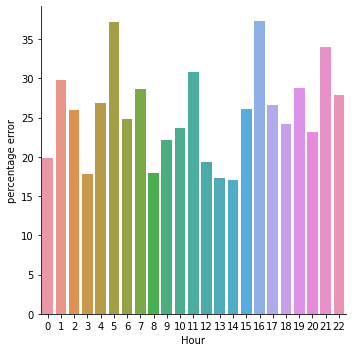

In [97]:
sns.factorplot(x="Hour",y="percentage error",data=df_erreur,kind='bar')

Sur ce graphe, le pourcentage d'erreur est inscrit en fonction de l'heure. Il n'est pas possible de conclure quoi que ce soit.

## Conclusion 

Les données sont en trop peu nombres pour obtenir une prévision vraiment précise. Seulement deux semaines ont été étudiées, cela n'est pas assez. Une étude avec un plus grand nombre de données serait intéressant.